## Define universally relevant functions

For computing probs of model

In [317]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
def softmax(x):
    # Subtract the max value from x for numerical stability
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
def construct_U_inf(narrator,z_score_type,plot_title,states):
    U_inf = dict()
    for utterence in narrator['intensifier'].unique():
        data = narrator[narrator['intensifier'] == utterence][z_score_type]
        kde = gaussian_kde(data) # kde is used so there is no zero
        densities_at_new_point = kde(states)  # This is the density at the new point
        # below is same as marginalizing so adds up to 1
        # plot kde as graph
        
        plt.plot(states, densities_at_new_point, label=utterence)
        plt.legend()
        plt.title(plot_title)


        # plot barplot of data
        U_inf[utterence] = np.log(densities_at_new_point)-np.log(np.sum(densities_at_new_point))
    plt.show()
    return U_inf
def gaussian(s):
    # return a gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/2)
def U_s1(w,s,S,phi,U_inf,U_soc,cost=None):
    # corresponds to U_s1(w) in the paper
    if cost is None:
        return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*20)]
    if w[0] == 'none':
        # cost should be positive and represents how much easier it is to not have intensifier
        return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*20)]+cost
    return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*20)]
def construct_P_l1(U_inf,U_soc,possible_alpha,possible_phi,states,predicates,intensifiers,costs=None):
    P_l1 = dict()
    S = np.min(states)
    if costs  is None:
        P_s1 = dict()
        for alpha in possible_alpha:
                for phi in possible_phi:
                    for s in states:
                        # marginalized over all utterences with same predicate ('none','slightly' 'kind of' 'quite' 'very' 'extremely')
                        for pred in predicates:
                            P_s1[(alpha,phi,s,pred)] = softmax([ alpha*U_s1((w,pred),s,S,phi,U_inf,U_soc) for w in intensifiers])
        for alpha in possible_alpha:
            for phi in possible_phi:
                for i in range(len(intensifiers)):
                    for pred in predicates:
                        w = intensifiers[i]
                        P_l1[(alpha,phi,(w,pred))] = [P_s1[(alpha,phi,s,pred)][i]*gaussian(s) for s in states]
                        # normalize so adds up to 1
                        P_l1[(alpha,phi,(w,pred))] = P_l1[(alpha,phi,(w,pred))]/np.sum(P_l1[(alpha,phi,(w,pred))])
    else:
        for cost in costs:
            P_s1 = dict()
            for alpha in possible_alpha:
                for phi in possible_phi:
                    for s in states:
                        # marginalized over all utterences with same predicate ('none','slightly' 'kind of' 'quite' 'very' 'extremely')
                        for pred in predicates:
                            P_s1[(alpha,phi,s,pred)] = softmax([ alpha*U_s1((w,pred),s,S,phi,U_inf,U_soc,cost) for w in intensifiers])
            for alpha in possible_alpha:
                for phi in possible_phi:
                    for i in range(len(intensifiers)):
                        for pred in predicates:
                            w = intensifiers[i]
                            P_l1[(alpha,phi,(w,pred),cost)] = [P_s1[(alpha,phi,s,pred)][i]*gaussian(s) for s in states]
                            # normalize so adds up to 1
                            P_l1[(alpha,phi,(w,pred),cost)] = P_l1[(alpha,phi,(w,pred),cost)]/np.sum(P_l1[(alpha,phi,(w,pred),cost)])
    return P_l1

Function for testing fit to data based on logloss

In [318]:
def test_fit(dialogue,P_l1,z_score_type,possible_alpha,possible_phi,utterences,S,cost=None):
    # test fit of model, by returning log loss for each utterence
    log_loss=dict()    
    if cost is None:
        for w in utterences:
            log_loss[w] = np.zeros((len(possible_phi),len(possible_alpha)))
            measured_values = dialogue[((dialogue['intensifier'] == w[0]) & (dialogue['predicate'] == w[1]))][z_score_type].values
            for i in range(len(possible_phi)):
                for j in range(len(possible_alpha)):
                    log_loss[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int((s-S)*20)]) for s in measured_values)
    else:
        for w in utterences:
            log_loss[w] = np.zeros((len(possible_phi),len(possible_alpha)))
            measured_values = dialogue[((dialogue['intensifier'] == w[0]) & (dialogue['predicate'] == w[1]))][z_score_type].values
            # print minimum of measured values
            for i in range(len(possible_phi)):
                for j in range(len(possible_alpha)):
                    log_loss[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)
    return log_loss

# Version with cost

In [319]:
import pandas as pd
import matplotlib.pyplot as plt

# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
politeness = pd.concat([dataframes[1], dataframes[4]])
narrator = pd.concat([dataframes[2], dataframes[5]])
UK_narrator = dataframes[2]
US_narrator = dataframes[5]
UK_dialogue = dataframes[0]
US_dialogue = dataframes[3]
dialogue = pd.concat([dataframes[0], dataframes[3]])
# compute social utility
U_soc_pred = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()

-2.8 2.79


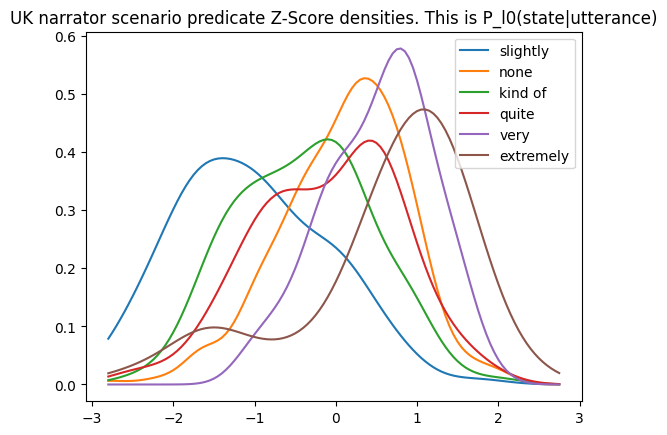

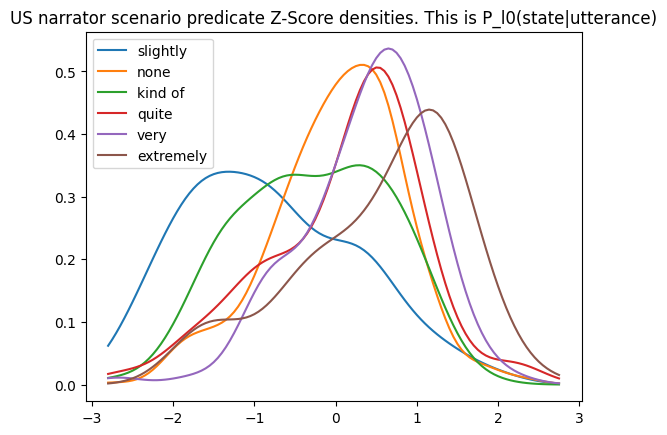

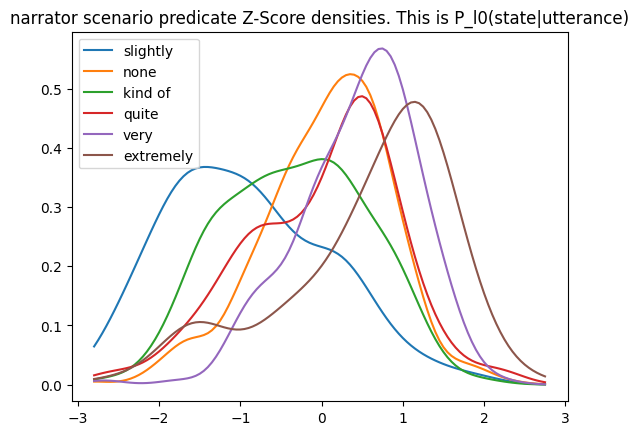

In [320]:
import numpy as np
costs = np.arange(0,1.6,0.1)
possible_phi = np.arange(0,1,0.05)
possible_alpha = np.arange(0,4.5,0.15)
utterences =list(U_soc_pred.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
min_state = np.min(dialogue['predicate Z-score'].values)-0.05
max_state = np.max(dialogue['predicate Z-score'].values)+0.1
# round to 2 d.p
min_state = round(min_state,2)
max_state = round(max_state,2)
print(min_state,max_state)
states = np.arange(min_state,max_state, 0.05)
S = np.min(states)
UK_U_inf = construct_U_inf(UK_narrator,'predicate Z-score','UK narrator scenario predicate Z-Score densities. This is P_l0(state|utterance)',states)
US_U_inf = construct_U_inf(US_narrator,'predicate Z-score','US narrator scenario predicate Z-Score densities. This is P_l0(state|utterance)',states)
U_inf = construct_U_inf(narrator,'predicate Z-score','narrator scenario predicate Z-Score densities. This is P_l0(state|utterance)',states)
pred_UK_P_l1 = construct_P_l1(UK_U_inf,U_soc_pred,possible_alpha,possible_phi,states,predicates,intensifiers,costs)
pred_US_P_l1 = construct_P_l1(US_U_inf,U_soc_pred,possible_alpha,possible_phi,states,predicates,intensifiers,costs)
pred_both_P_l1 = construct_P_l1(U_inf,U_soc_pred,possible_alpha,possible_phi,states,predicates,intensifiers,costs)

In [321]:
# compute loglosses for each cost
pred_UK_loglosses = []
pred_US_loglosses = []
pred_both_loglosses = []
pred_both_to_UK_loglosses = []
pred_both_to_US_loglosses = []
for cost in costs:
    pred_UK_loglosses.append(test_fit(UK_dialogue,pred_UK_P_l1,'predicate Z-score',possible_alpha,possible_phi,utterences,S,cost))
    pred_US_loglosses.append(test_fit(US_dialogue,pred_US_P_l1,'predicate Z-score',possible_alpha,possible_phi,utterences,S,cost))
    pred_both_loglosses.append(test_fit(dialogue,pred_both_P_l1,'predicate Z-score',possible_alpha,possible_phi,utterences,S,cost))
    pred_both_to_UK_loglosses.append(test_fit(UK_dialogue,pred_both_P_l1,'predicate Z-score',possible_alpha,possible_phi,utterences,S,cost))
    pred_both_to_US_loglosses.append(test_fit(US_dialogue,pred_both_P_l1,'predicate Z-score',possible_alpha,possible_phi,utterences,S,cost))

C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\200963580.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_loss[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


# Version without cost (taking difs)

In [322]:
import pandas as pd
import matplotlib.pyplot as plt

# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def clean_data(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    # only keep columns with has_intensifier = yes
    return df[df['has intensifier?'] == 'yes']
for i in range(len(dataframes)):
    dataframes[i] = clean_data(dataframes[i])
politeness = pd.concat([dataframes[1], dataframes[4]])
narrator = pd.concat([dataframes[2], dataframes[5]])
dialogue = pd.concat([dataframes[0], dataframes[3]])
UK_dialogue = dataframes[0]
UK_politeness = dataframes[1]
UK_narrator = dataframes[2]
US_dialogue = dataframes[3]
US_politeness = dataframes[4]
US_narrator = dataframes[5]
# compute social utility
U_soc_dif = politeness.groupby(['intensifier','predicate'])['Z-Score Difference'].mean().to_dict()

-5.6556707182862915 4.444098662666472


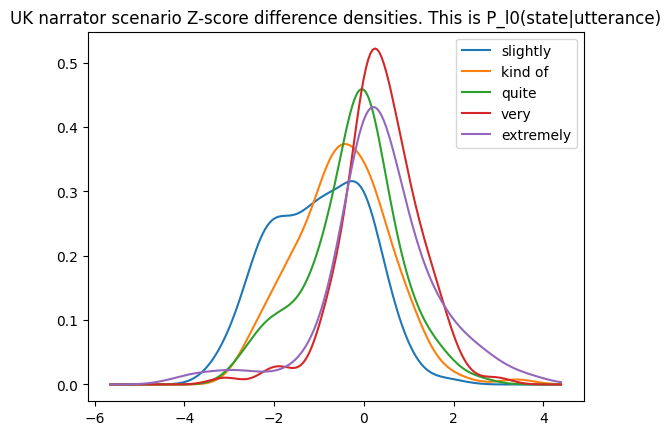

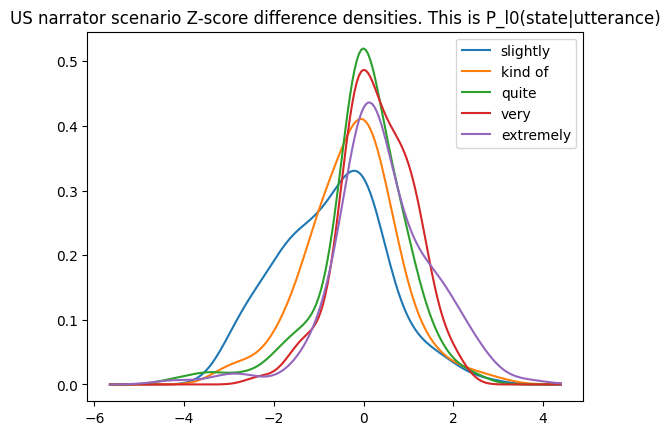

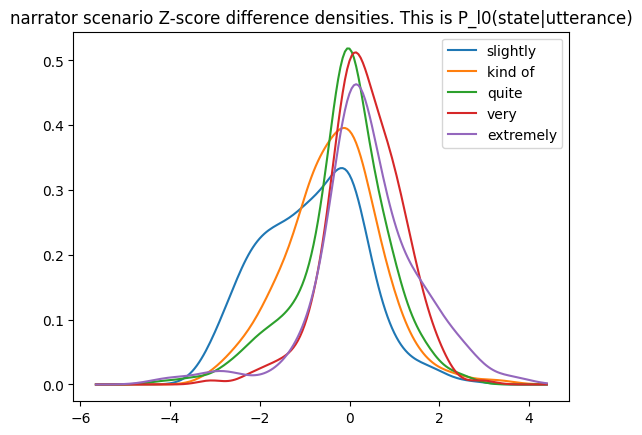

In [323]:
import numpy as np

min_state = np.min(dialogue['Z-Score Difference'].values)-0.05
max_state = np.max(dialogue['Z-Score Difference'].values)+0.05
print(min_state,max_state)
utterences =list(U_soc_dif.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
possible_phi = np.arange(0,1,0.05)
possible_alpha = np.arange(0,4.5,0.15)
states = np.arange(min_state,max_state, 0.05)
S = min_state
UK_U_inf = construct_U_inf(UK_narrator,'Z-Score Difference','UK narrator scenario Z-score difference densities. This is P_l0(state|utterance)',states)
US_U_inf = construct_U_inf(US_narrator,'Z-Score Difference','US narrator scenario Z-score difference densities. This is P_l0(state|utterance)',states)
U_inf = construct_U_inf(narrator,'Z-Score Difference','narrator scenario Z-score difference densities. This is P_l0(state|utterance)',states)
dif_UK_P_l1 = construct_P_l1(UK_U_inf,U_soc_dif,possible_alpha,possible_phi,states,predicates,intensifiers)
dif_US_P_l1 = construct_P_l1(US_U_inf,U_soc_dif,possible_alpha,possible_phi,states,predicates,intensifiers)
dif_both_P_l1 = construct_P_l1(U_inf,U_soc_dif,possible_alpha,possible_phi,states,predicates,intensifiers)


In [325]:
dif_UK_logloss = test_fit(UK_dialogue,dif_UK_P_l1,'Z-Score Difference',possible_alpha,possible_phi,utterences,S)
dif_US_logloss = test_fit(US_dialogue,dif_US_P_l1,'Z-Score Difference',possible_alpha,possible_phi,utterences,S)
dif_both_logloss = test_fit(dialogue,dif_both_P_l1,'Z-Score Difference',possible_alpha,possible_phi,utterences,S)
dif_both_to_UK_logloss = test_fit(UK_dialogue,dif_both_P_l1,'Z-Score Difference',possible_alpha,possible_phi,utterences,S)
dif_both_to_US_logloss = test_fit(US_dialogue,dif_both_P_l1,'Z-Score Difference',possible_alpha,possible_phi,utterences,S)

C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\200963580.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_loss[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int((s-S)*20)]) for s in measured_values)


## Functions for visualizing results

In [ ]:
def best_coord_val(fit_judgement):
    best_coord = np.unravel_index(np.argmax(fit_judgement, axis=None),fit_judgement.shape)
    best_val = fit_judgement[best_coord]
    return best_coord, best_val

UK specific model fitted to UK data: ((9, 19), -3290.509028463917)
US specific model fitted to US data: ((13, 21), -4041.5807616501857)
same P_l1 model fitted to all data: ((10, 17), -7339.704795183465)
same P_l1 model fitted to UK data: ((9, 20), -3288.7078609050213)
same P_l1 model fitted to US data: ((10, 14), -4041.3148595787397)


In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
custom_cmap = ListedColormap(colors)
def plot_overall_fit(fit_judgement, possible_alpha, possible_phi,title,minus_thresh,utterences):
    # Define a normalization function
    threshold = np.max(np.sum([fit_judgement[w] for w in utterences],axis=0))+minus_thresh
    bounds = [-20000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[w] for w in utterences],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[w] for w in utterences],axis=0), cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label x and y axis
    plt.xlabel('alpha')
    plt.ylabel('phi (weight on social utility)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title(title)
    # plt.colorbar()
    plt.show()
    
def fit_per_utterance(data,title, possible_alpha, possible_phi):
    rows, cols = len(predicates),len(intensifiers)
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 25))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        maximum = np.max(data[utterences[i]])
        bounds = [-10000, maximum-3] + list(np.linspace(maximum-3, maximum, 256))
        norm = BoundaryNorm(bounds, len(bounds) - 1)
        sns.heatmap(data[utterences[i]],ax=ax, cmap=custom_cmap, norm=norm, cbar=True)
        ax.set_title(f"{utterences[i]}")
        # label x and y by the possible values
        ax.set_xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
        ax.set_yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
        # rotate y ticks by 90
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig.suptitle(title, fontsize=16)
    # Adjust layout to prevent overlapping
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    # Show the plots
    plt.show()

def cost_subplots(fit_judgements, possible_alpha, possible_phi,title):
    # Create subplots
    fig, axes = plt.subplots(4,4, figsize=(30,30))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        maximum = np.max(np.sum([fit_judgements[i][w] for w in utterences],axis=0))
        bounds = [-20000, maximum-10] + list(np.linspace(maximum-10, maximum, 256))
        norm = BoundaryNorm(bounds, len(bounds) - 1)
        sns.heatmap(np.sum([fit_judgements[i][w] for w in utterences],axis=0),ax=ax, cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
        # label x and y axis
        ax.set_xlabel('alpha')
        ax.set_ylabel('phi (weight on social utility)')
    
    
        ax.set_title(f"{costs[i]}")
        # label x and y by the possible values
        ax.set_xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
        ax.set_yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
        # rotate y ticks by 90
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # Show the plots
    fig.suptitle(title, fontsize=16)
    # Adjust layout to prevent overlapping
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Visualizing with cost results

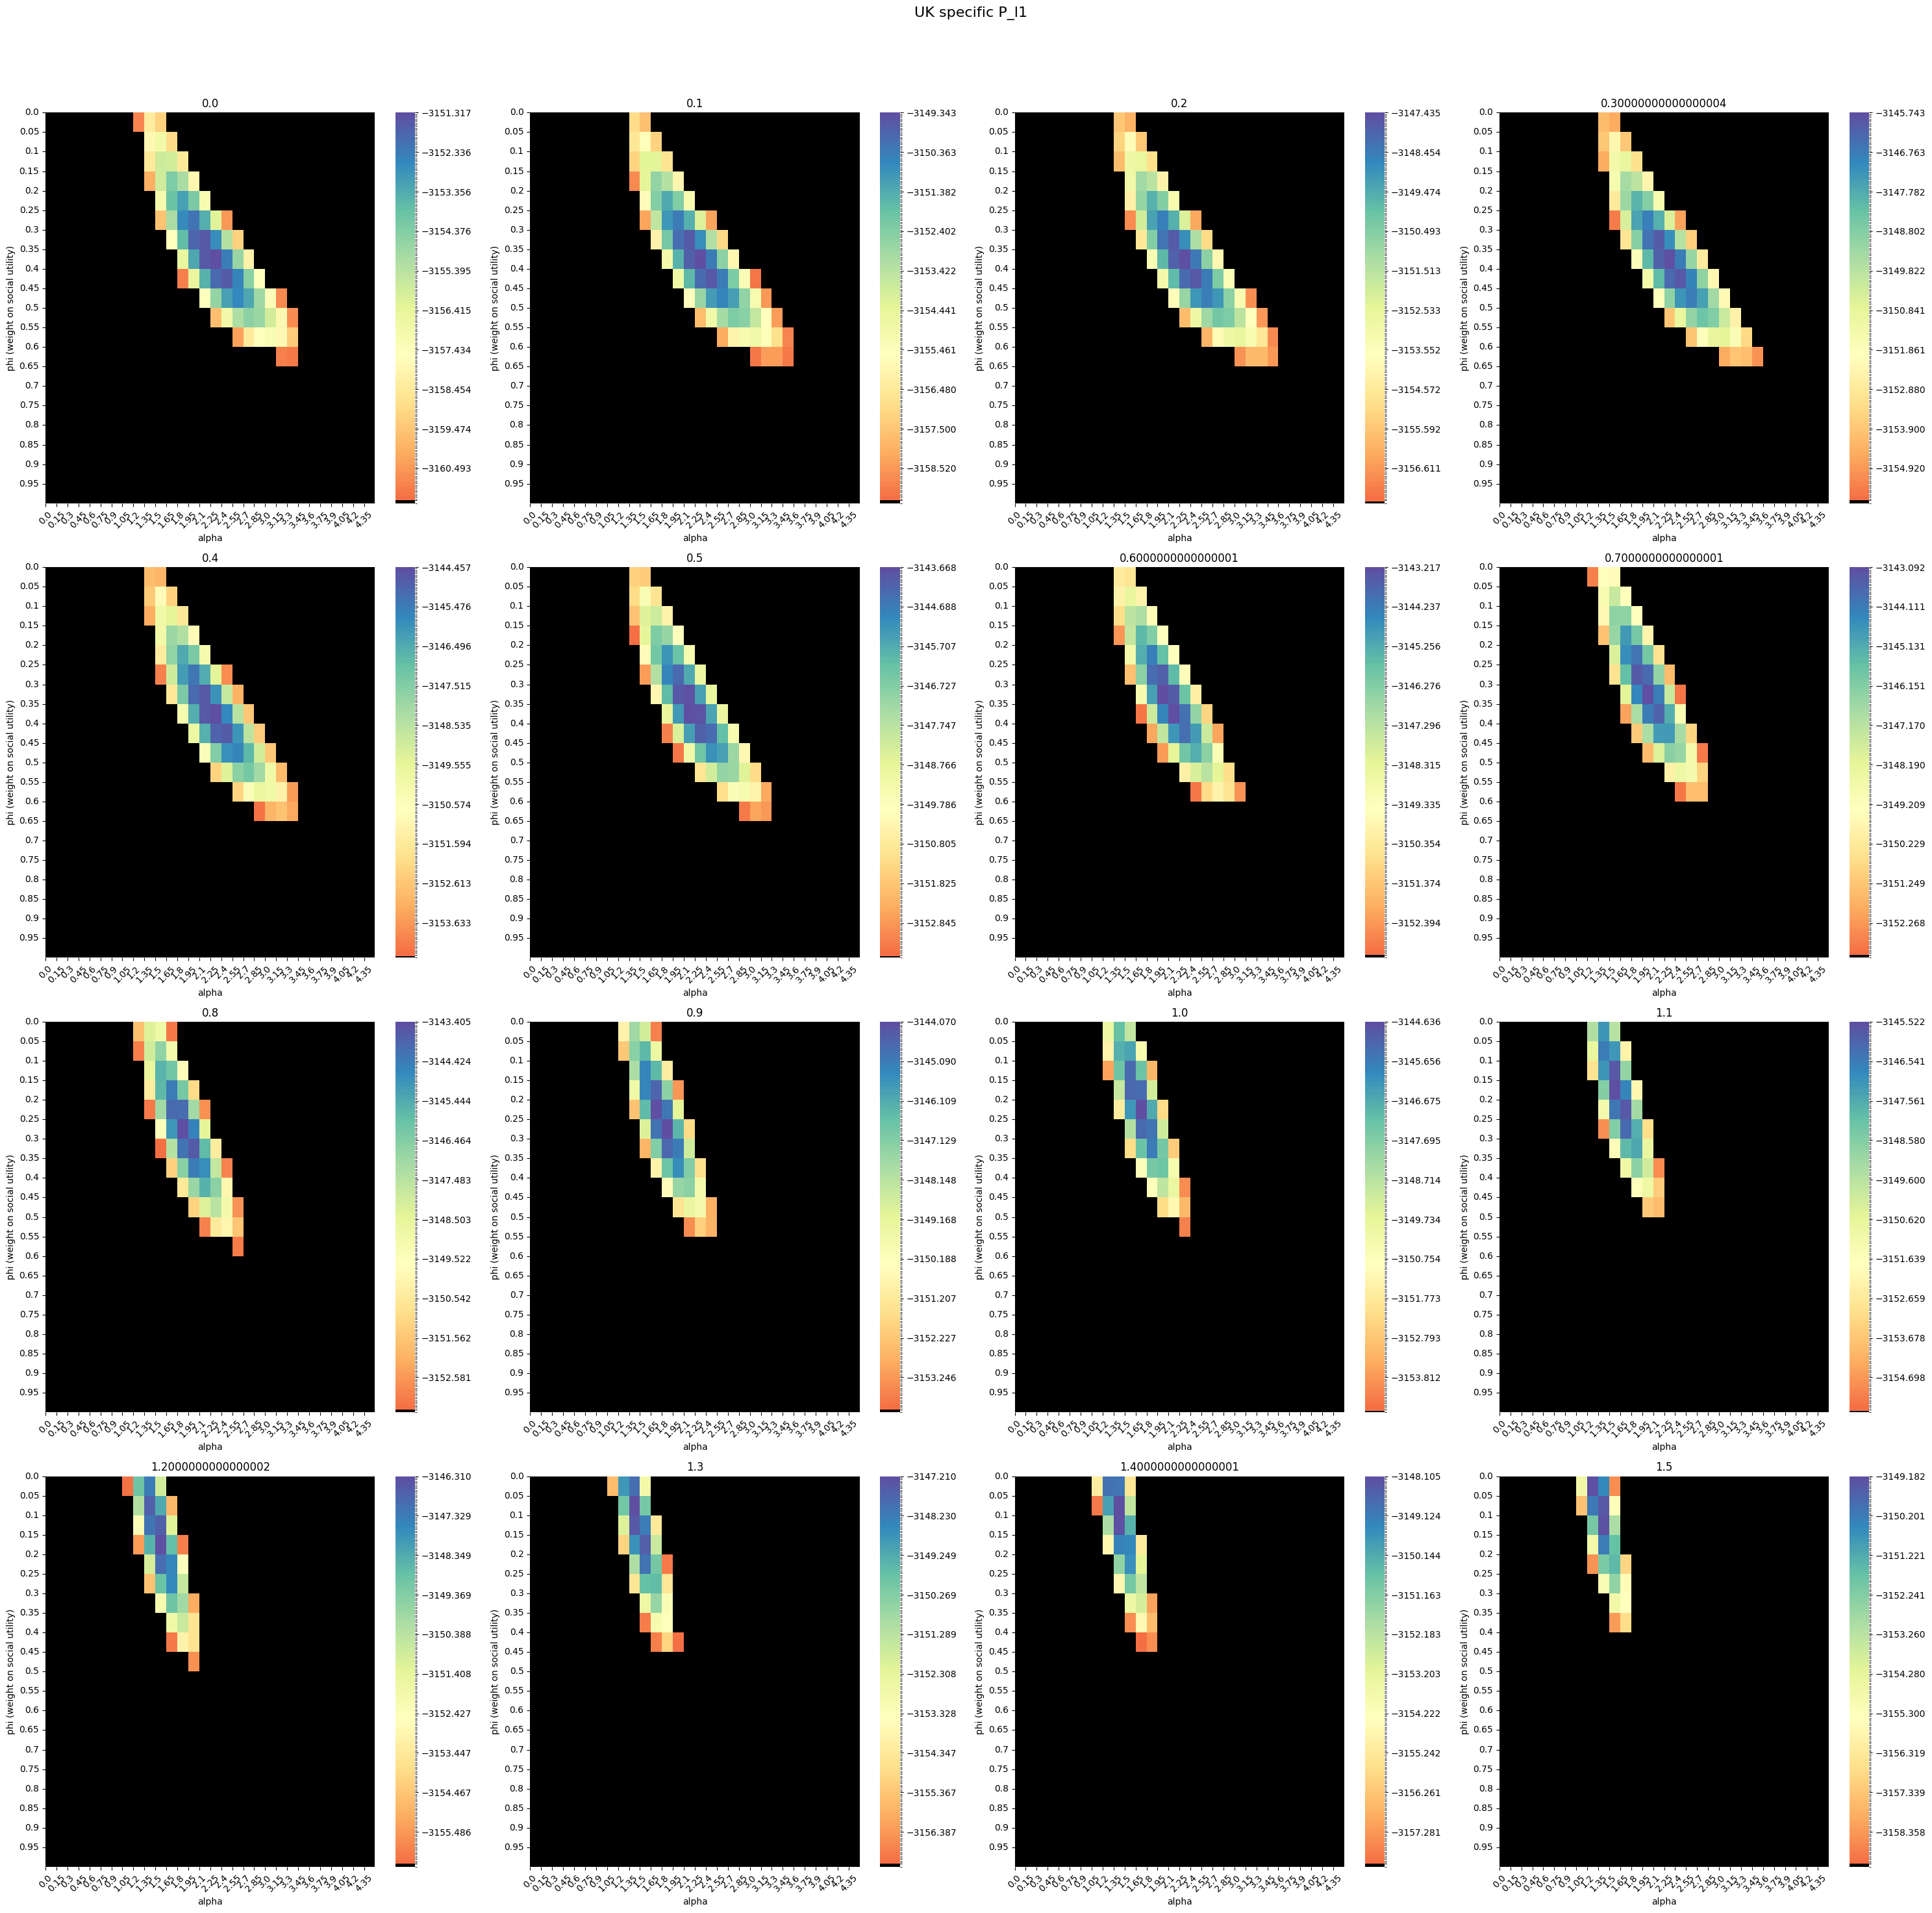

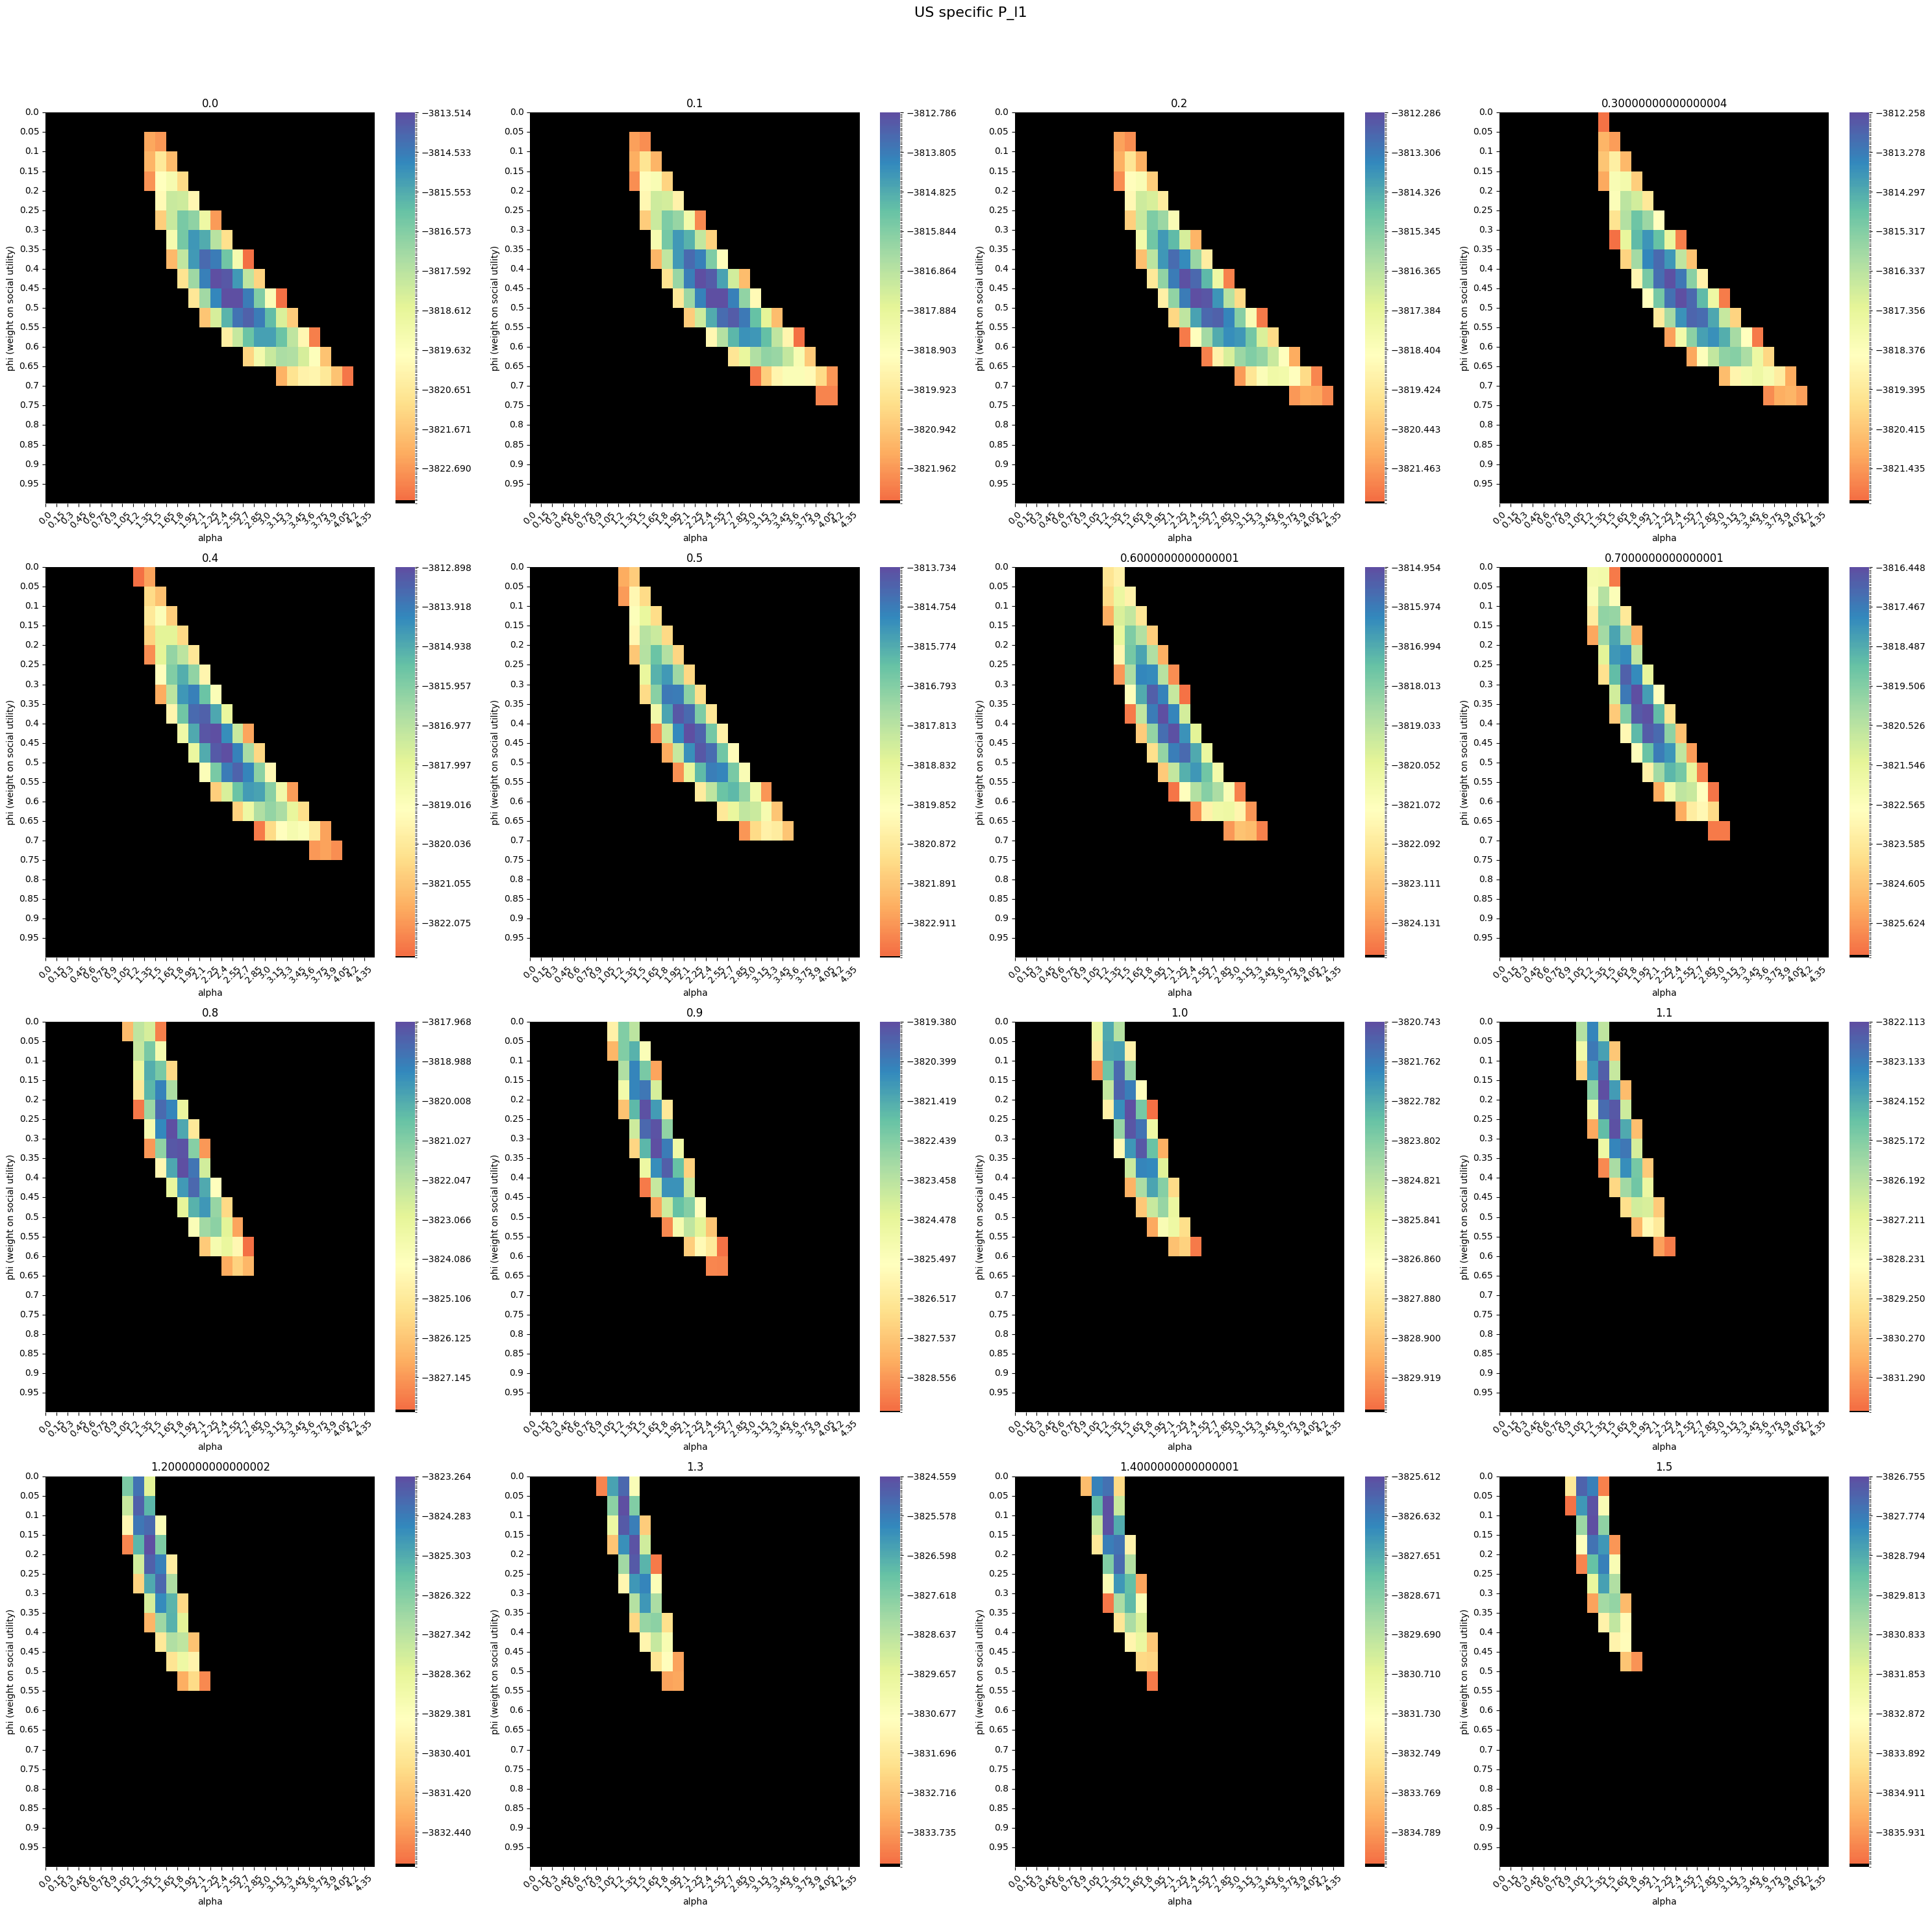

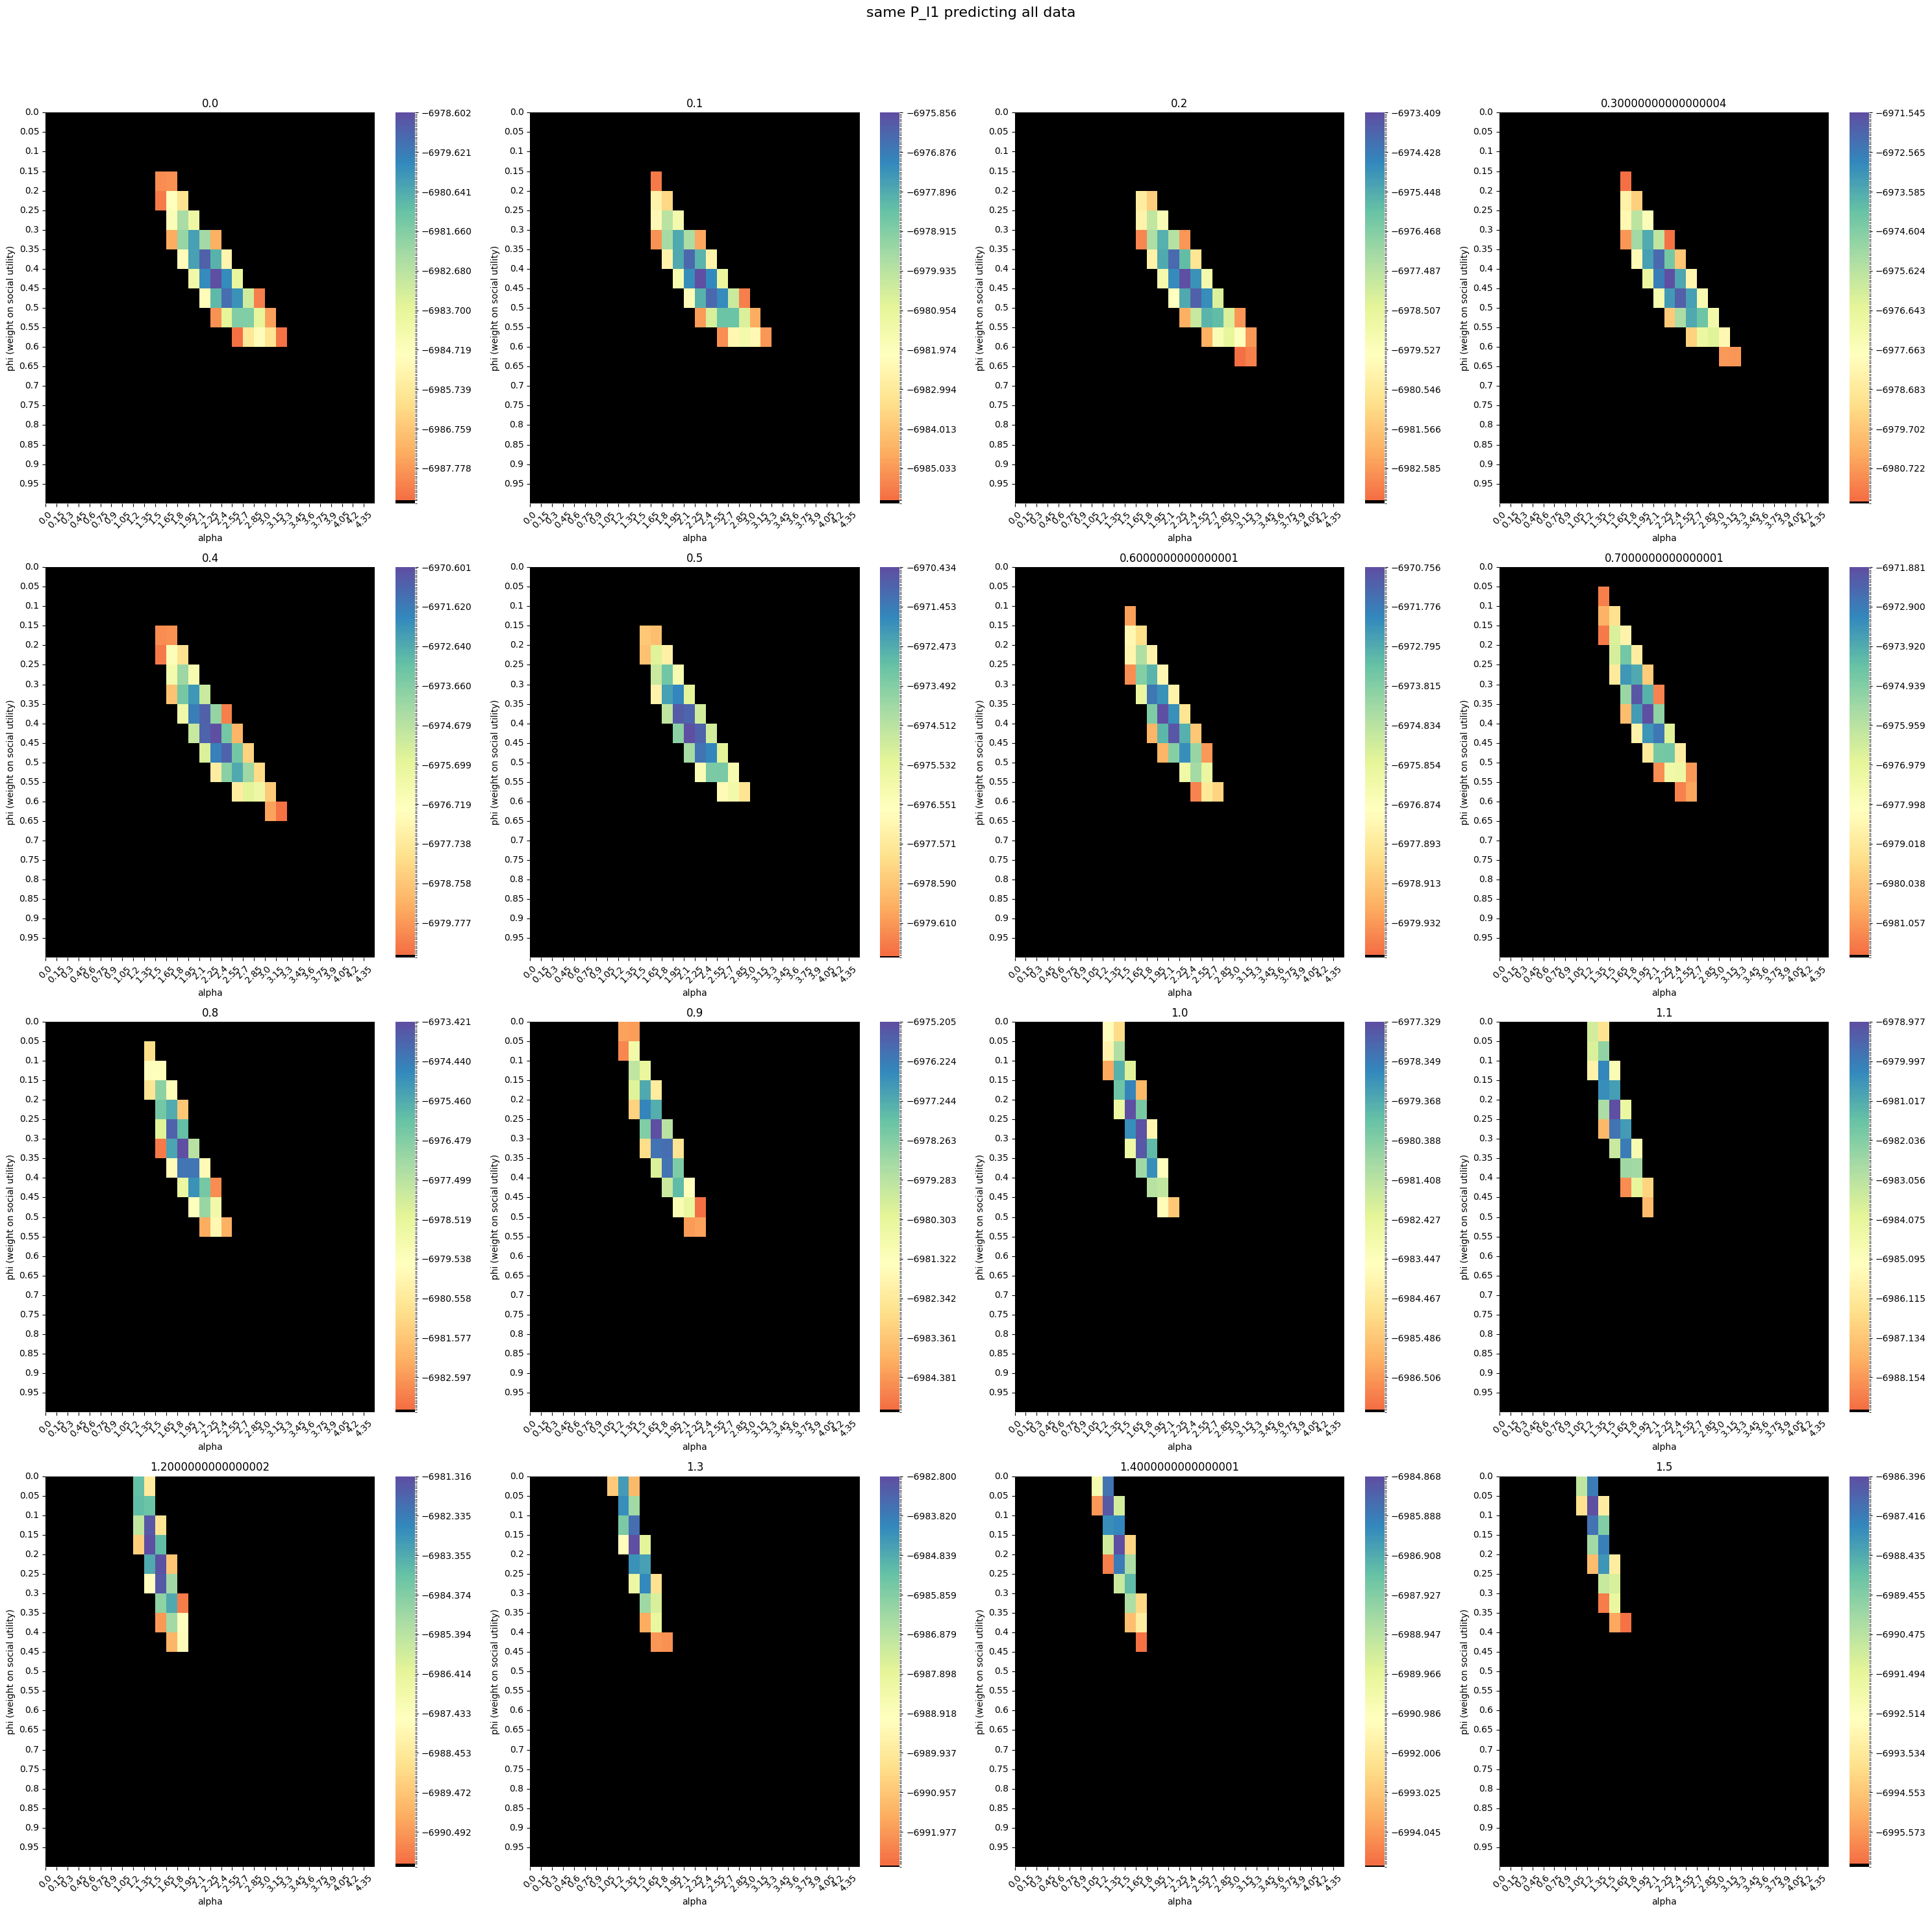

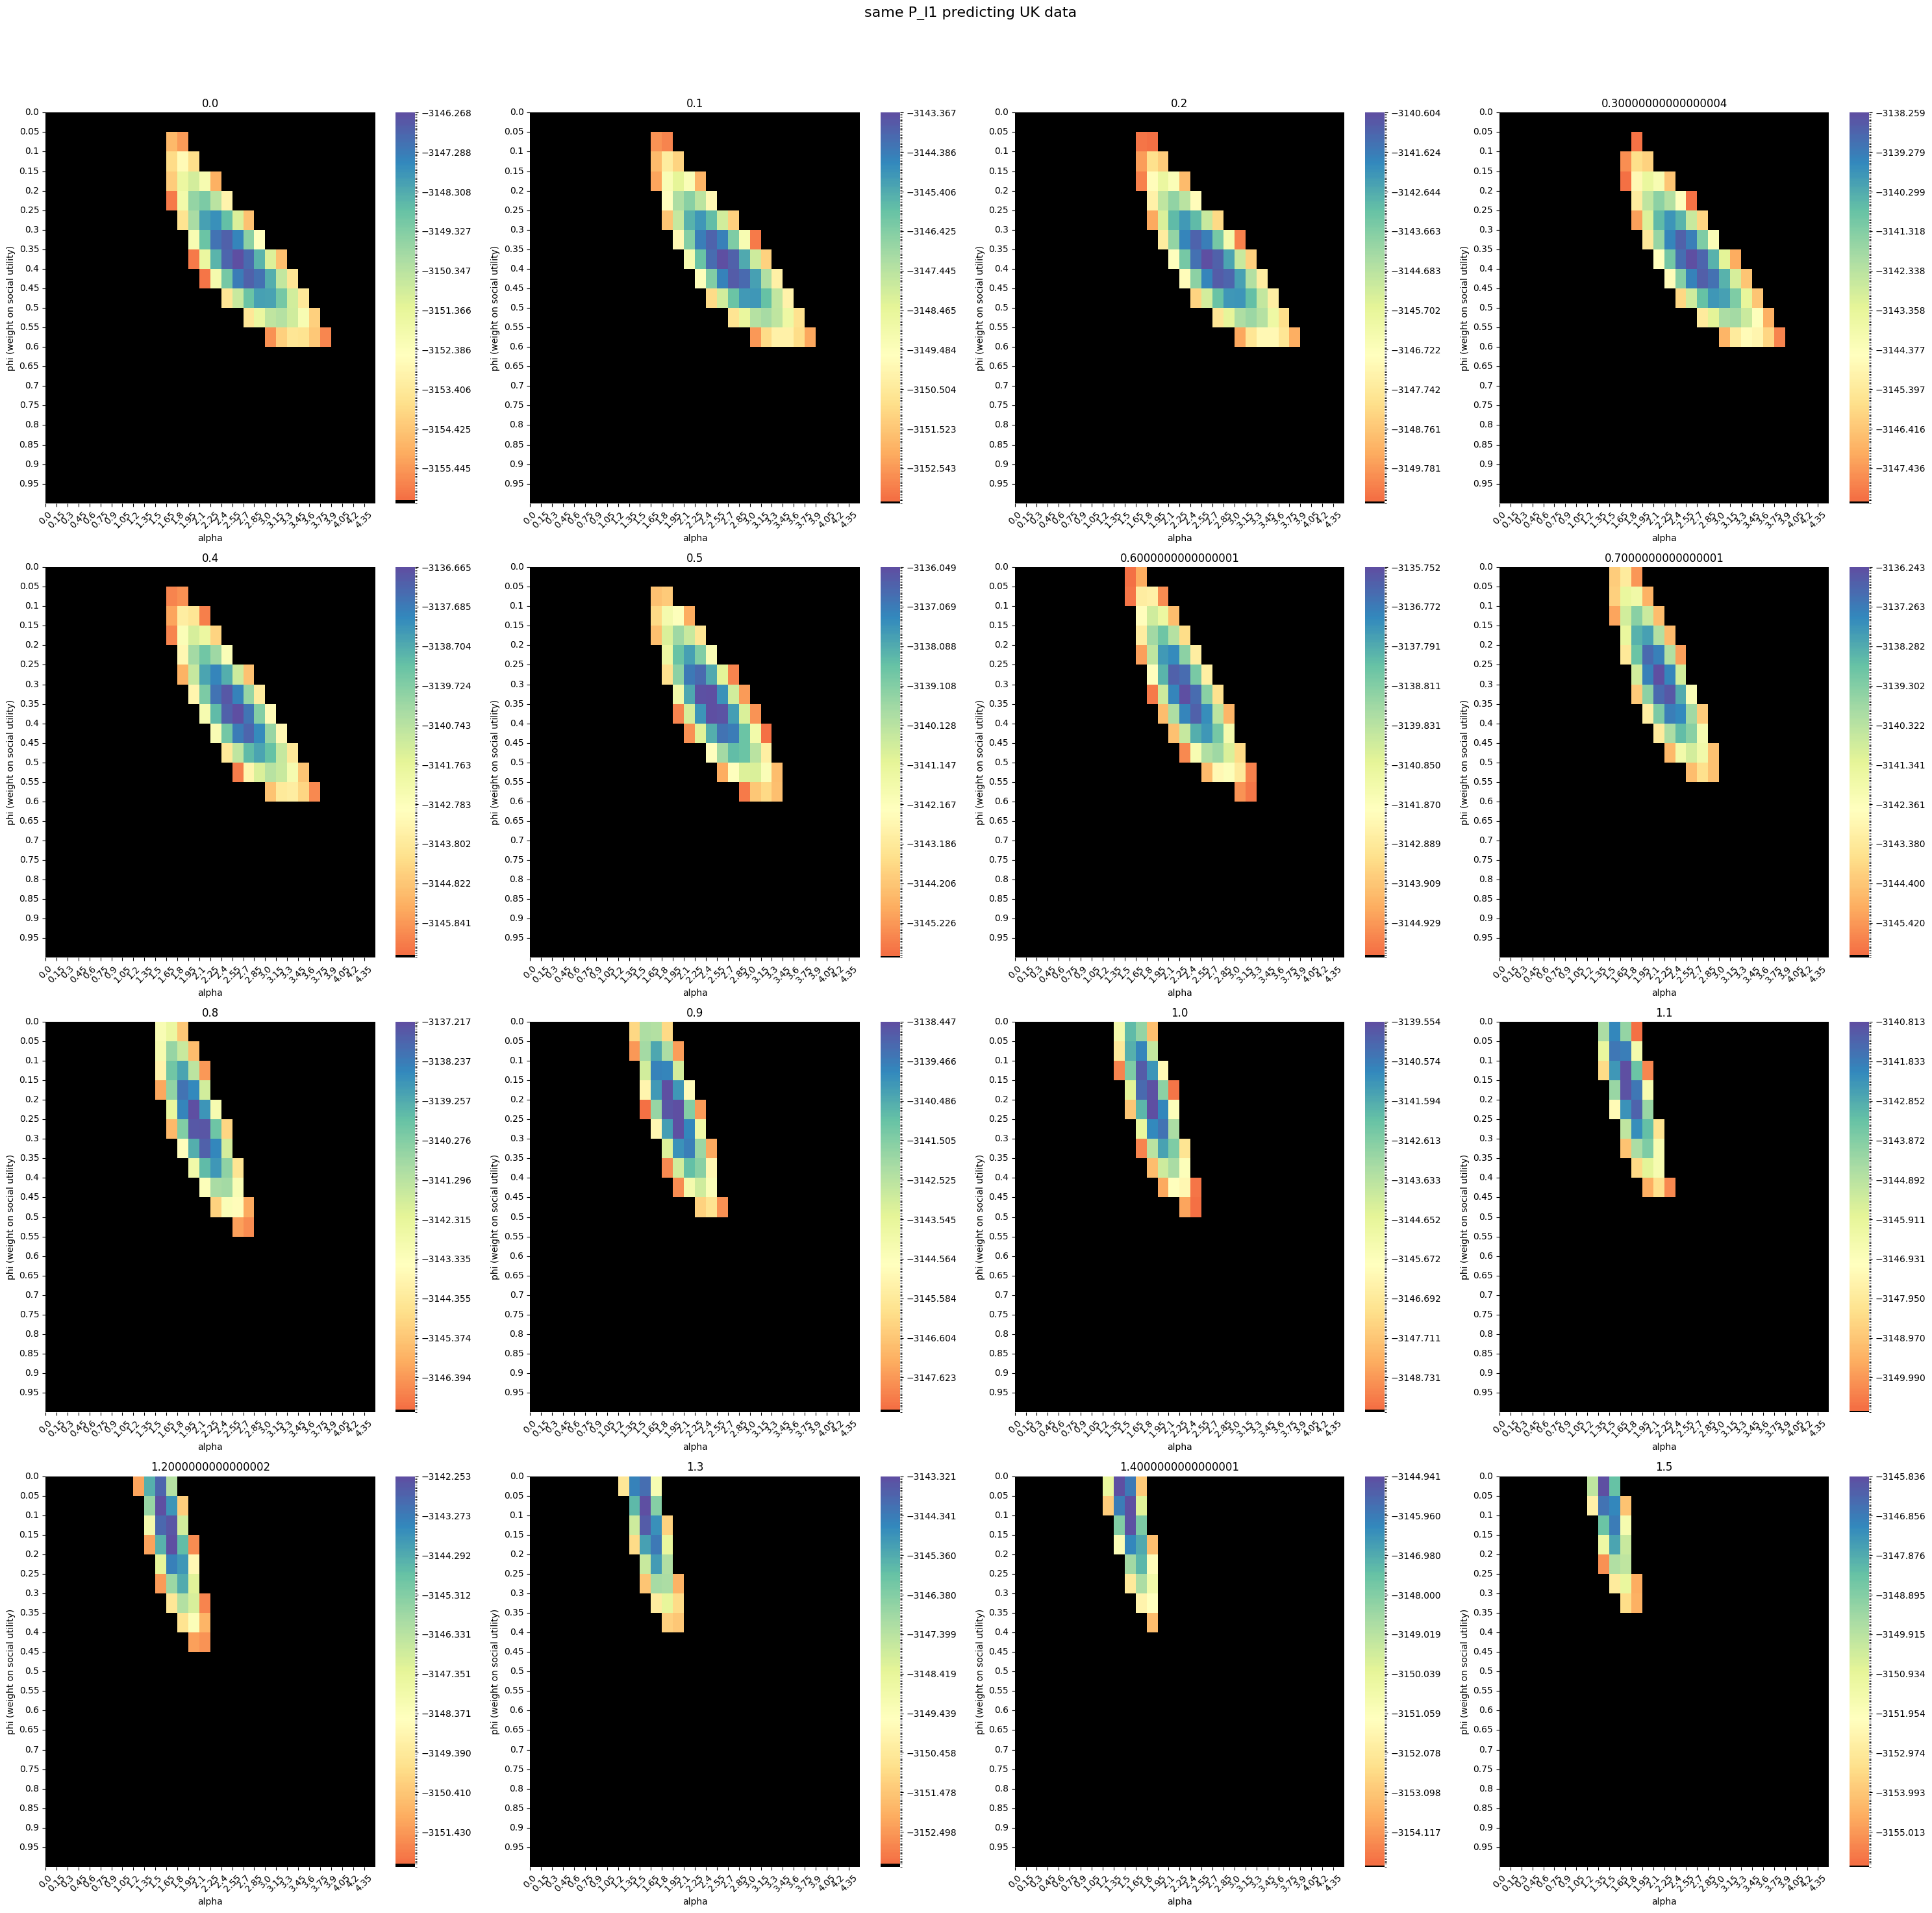

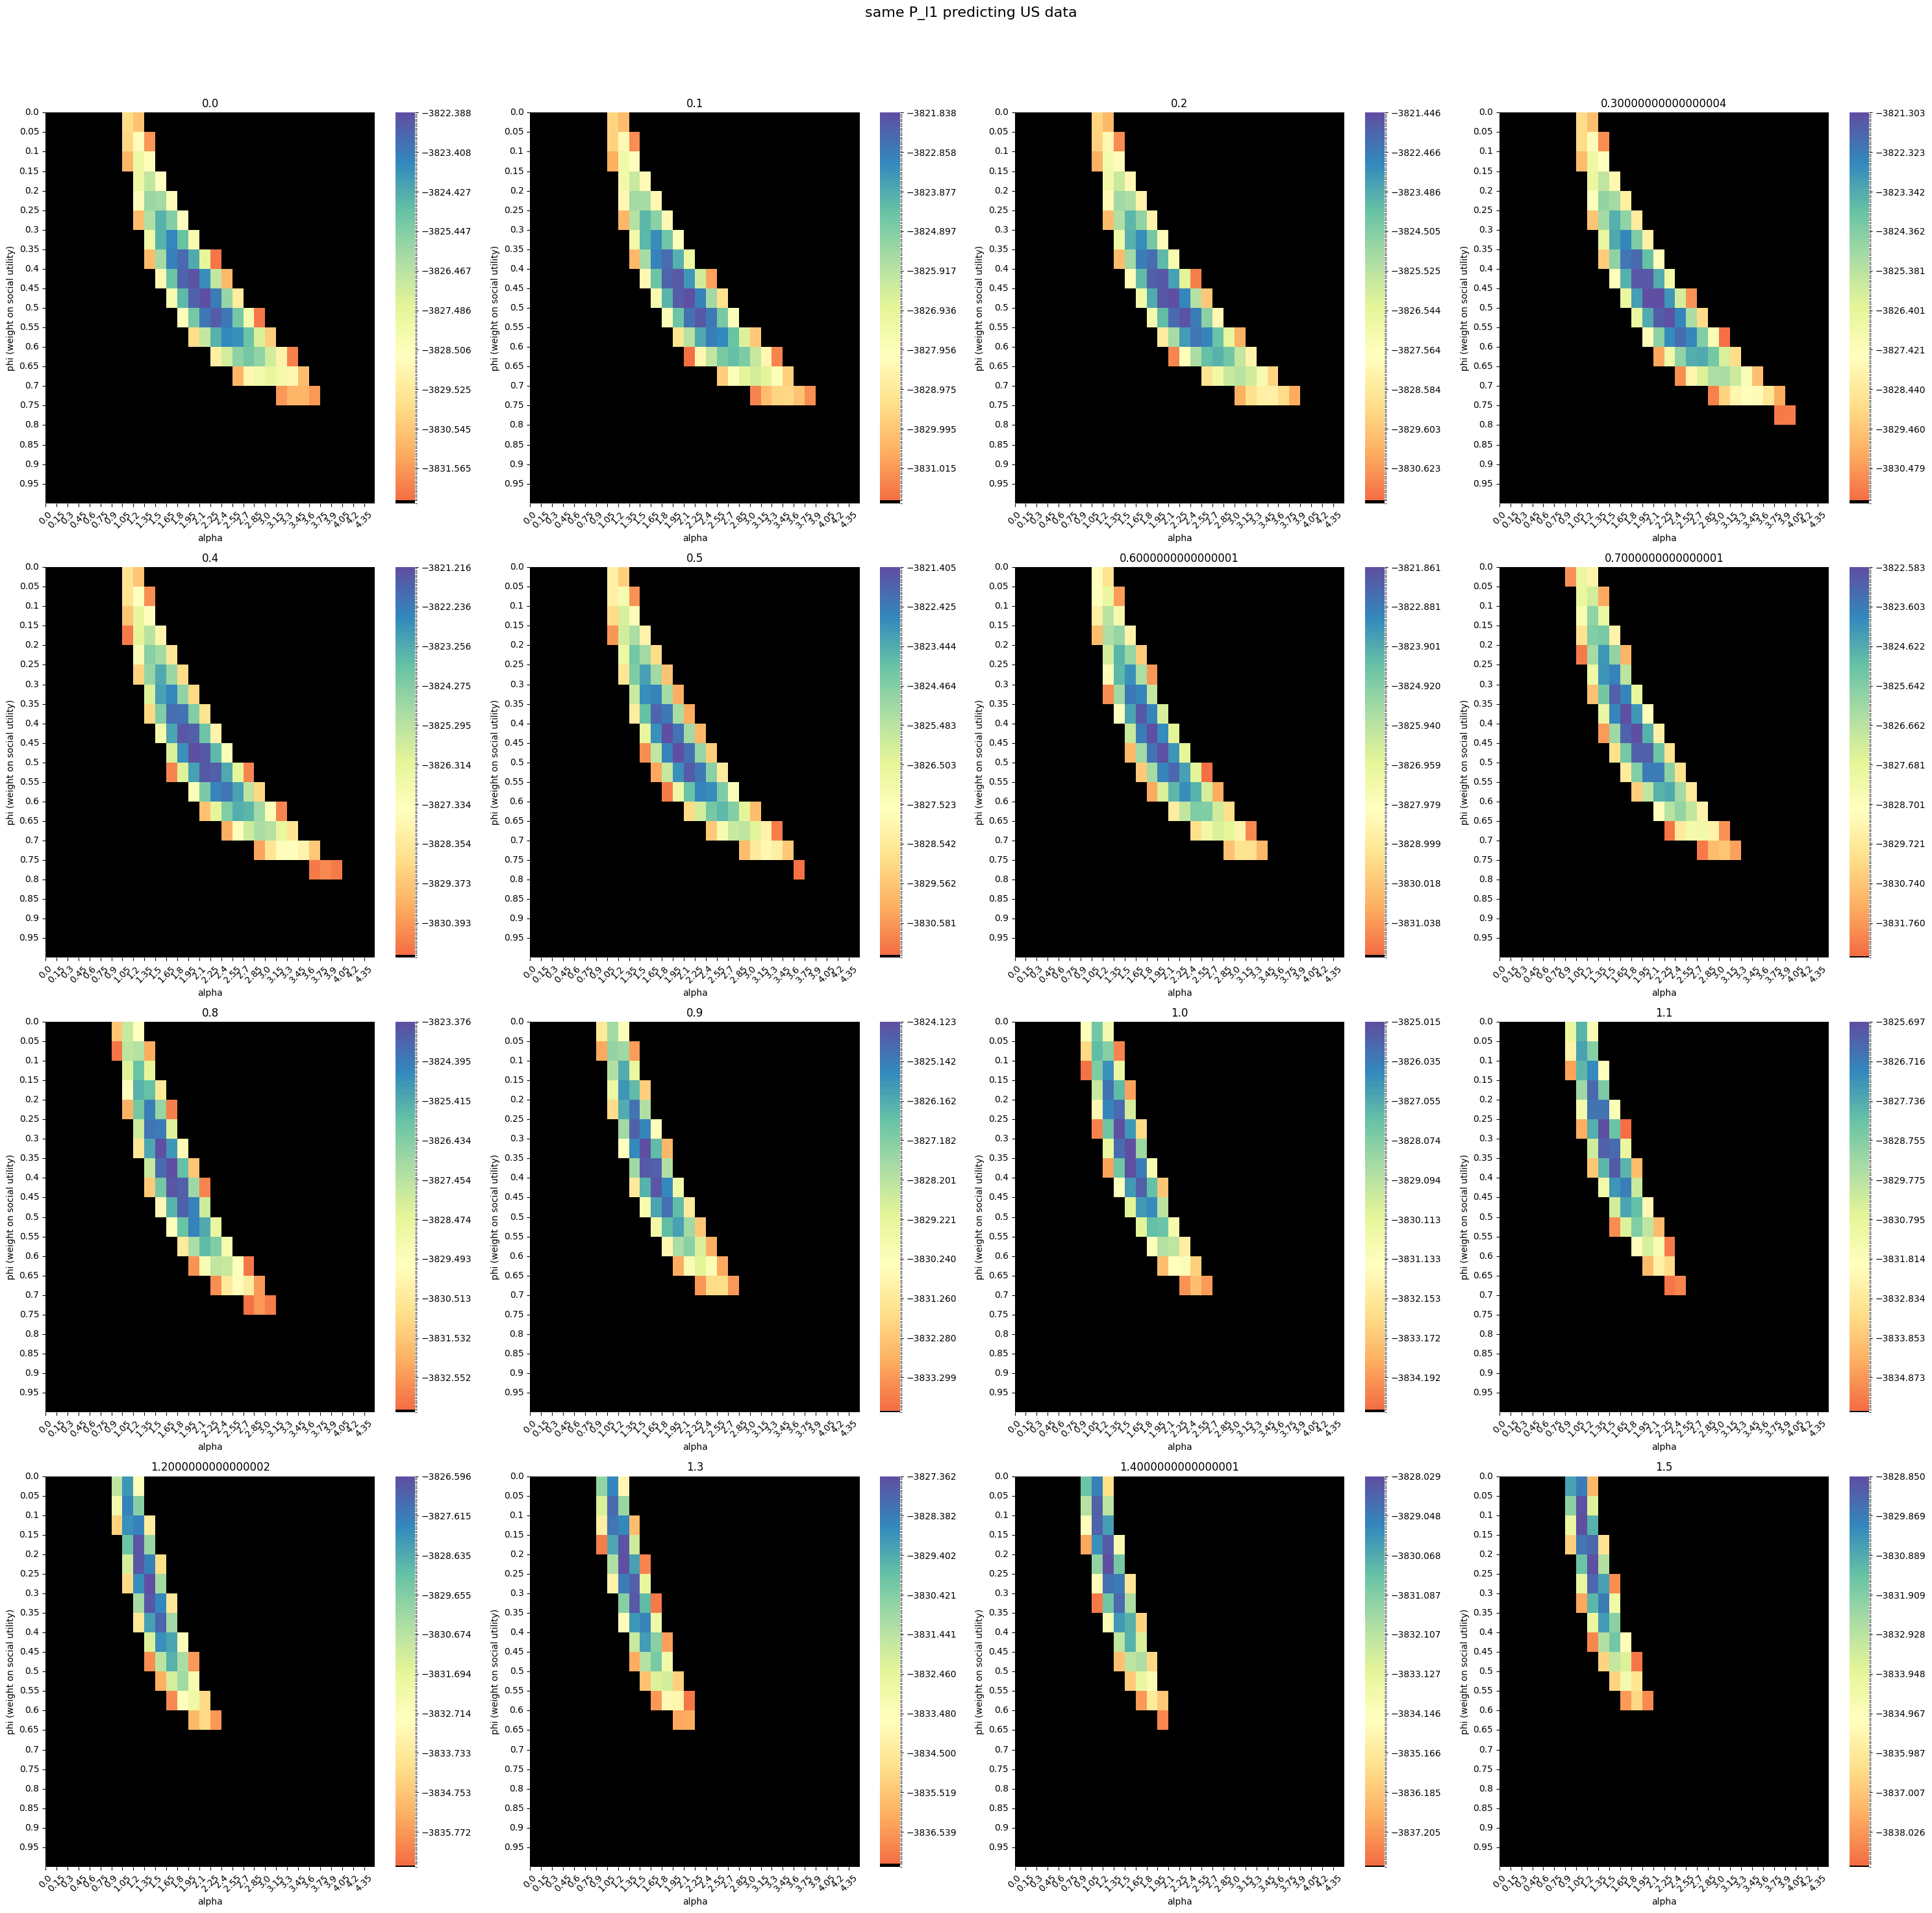

In [335]:
cost_subplots(pred_UK_loglosses,possible_alpha,possible_phi,"UK specific P_l1")
cost_subplots(pred_US_loglosses,possible_alpha,possible_phi,"US specific P_l1")
cost_subplots(pred_both_loglosses,possible_alpha,possible_phi,"same P_l1 predicting all data")
cost_subplots(pred_both_to_UK_loglosses,possible_alpha,possible_phi,"same P_l1 predicting UK data")
cost_subplots(pred_both_to_US_loglosses,possible_alpha,possible_phi,"same P_l1 predicting US data")

Graph of how loss, phi and alpha vary with cost

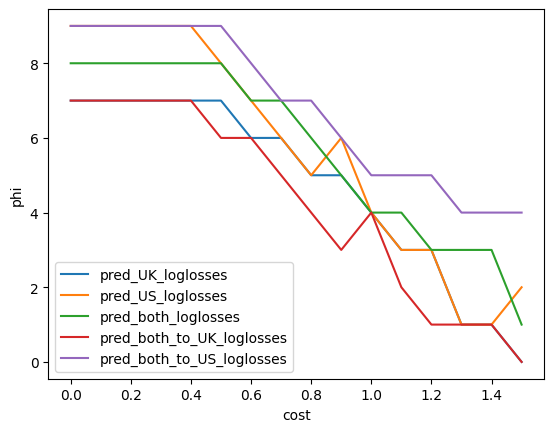

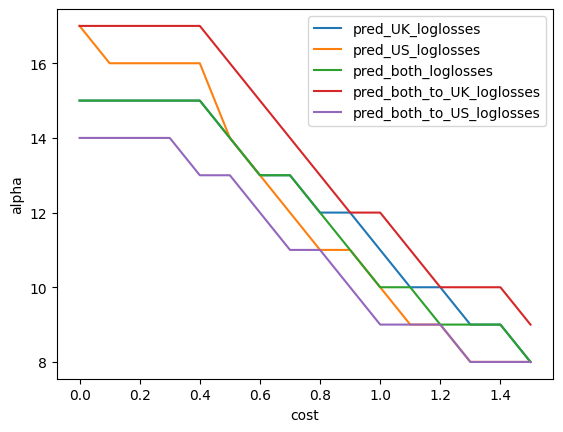

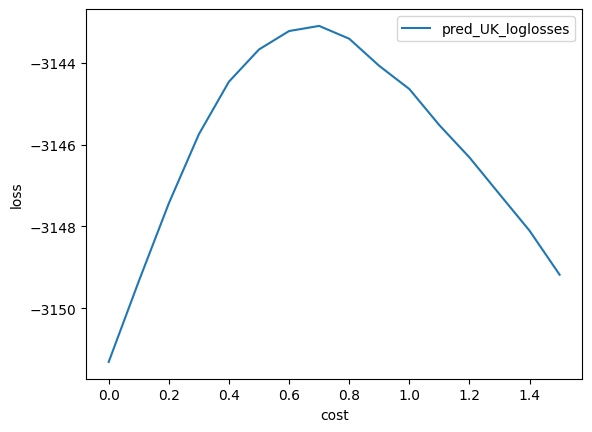

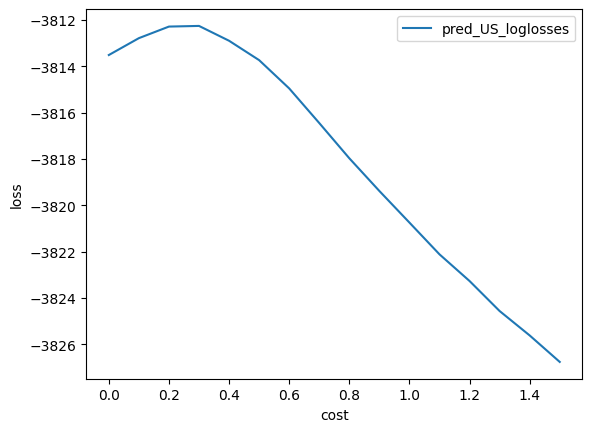

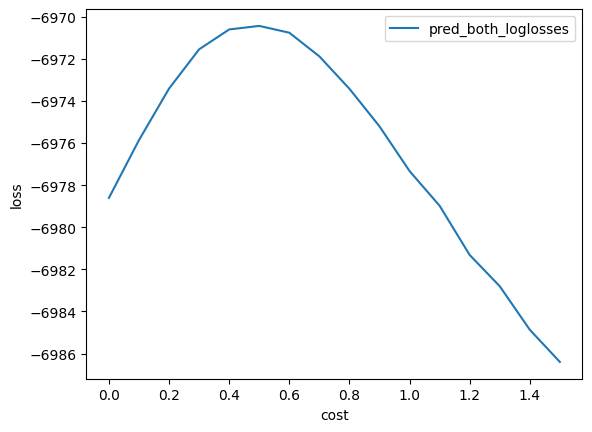

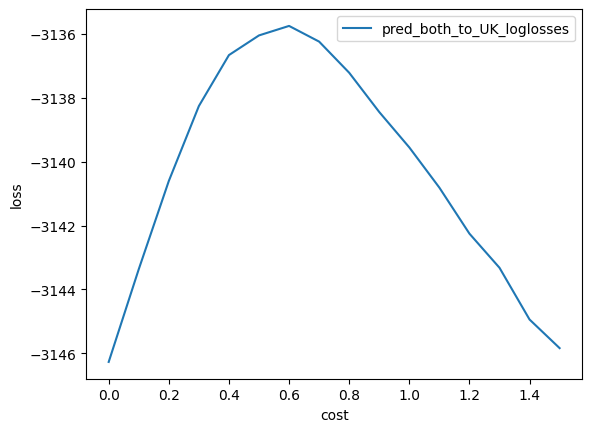

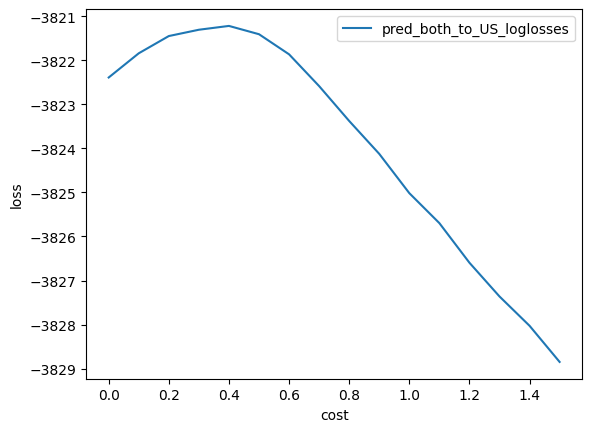

In [343]:
loss_with_cost = dict()
phi_with_cost = dict()
alpha_with_cost = dict()
datas = [pred_UK_loglosses,pred_US_loglosses,pred_both_loglosses,pred_both_to_UK_loglosses,pred_both_to_US_loglosses]
data_names = ['pred_UK_loglosses','pred_US_loglosses','pred_both_loglosses','pred_both_to_UK_loglosses','pred_both_to_US_loglosses']
for j in range(len(data_names)):
    best_vals = []
    best_phis = []
    best_alphas = []
    for i in range(len(costs)):
        data = datas[j]
        name = data_names[j]
        best_coord, best_val = best_coord_val(np.sum([data[i][w] for w in utterences],axis=0))
        best_vals.append(best_val)
        best_phis.append(best_coord[0])
        best_alphas.append(best_coord[1])
    loss_with_cost[name] = best_vals
    phi_with_cost[name] = best_phis
    alpha_with_cost[name] = best_alphas
# plot line plot of loss with cost
for i in range(len(data_names)):
    plt.plot(costs,phi_with_cost[data_names[i]],label=data_names[i])
    plt.legend()
    plt.xlabel('cost')
    plt.ylabel('phi')
plt.show()
# plot line plot of alpha with cost
for i in range(len(data_names)):
    plt.plot(costs,alpha_with_cost[data_names[i]],label=data_names[i])
    plt.legend()
    plt.xlabel('cost')
    plt.ylabel('alpha')
plt.show()
# plot line plot of loss with cost
for i in range(len(data_names)):
    plt.plot(costs,loss_with_cost[data_names[i]],label=data_names[i])
    plt.legend()
    plt.xlabel('cost')
    plt.ylabel('loss')
    plt.show()


## Visualizing without cost results

In [337]:
print(f"UK specific model fitted to UK data: {best_coord_val(np.sum([dif_UK_logloss[w] for w in utterences],axis=0))}")
print(f"US specific model fitted to US data: {best_coord_val(np.sum([dif_US_logloss[w] for w in utterences],axis=0))}")
print(f"same P_l1 model fitted to all data: {best_coord_val(np.sum([dif_both_logloss[w] for w in utterences],axis=0))}")
print(f"same P_l1 model fitted to UK data: {best_coord_val(np.sum([dif_both_to_UK_logloss[w] for w in utterences],axis=0))}")
print(f"same P_l1 model fitted to US data: {best_coord_val(np.sum([dif_both_to_US_logloss[w] for w in utterences],axis=0))}")

UK specific model fitted to UK data: ((9, 19), -3290.509028463917)
US specific model fitted to US data: ((13, 21), -4041.5807616501857)
same P_l1 model fitted to all data: ((10, 17), -7339.704795183465)
same P_l1 model fitted to UK data: ((9, 20), -3288.7078609050213)
same P_l1 model fitted to US data: ((10, 14), -4041.3148595787397)


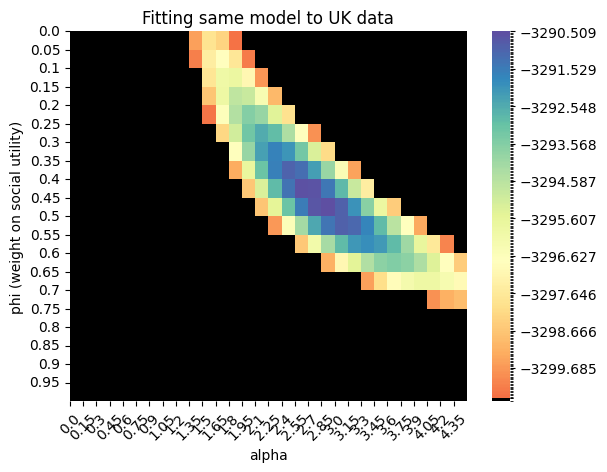

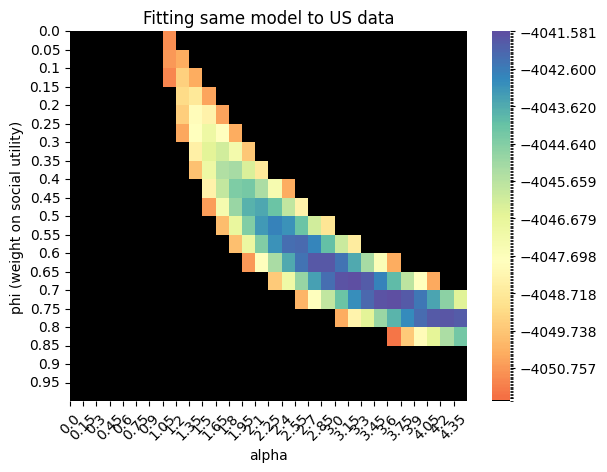

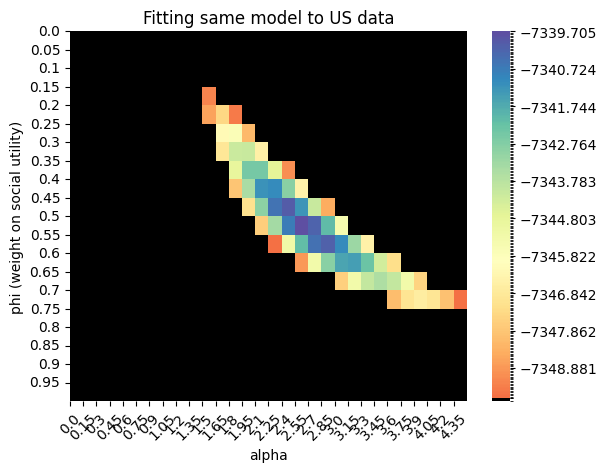

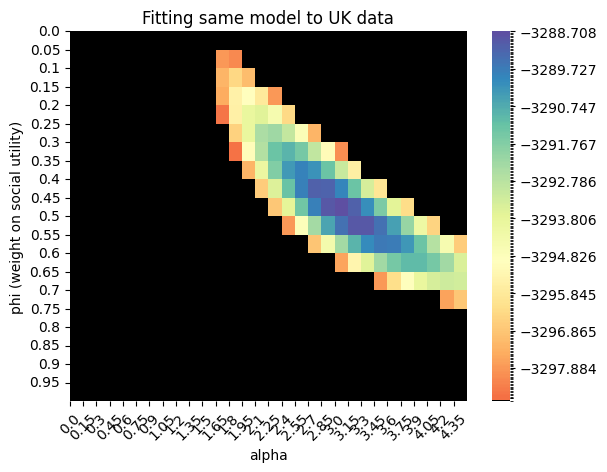

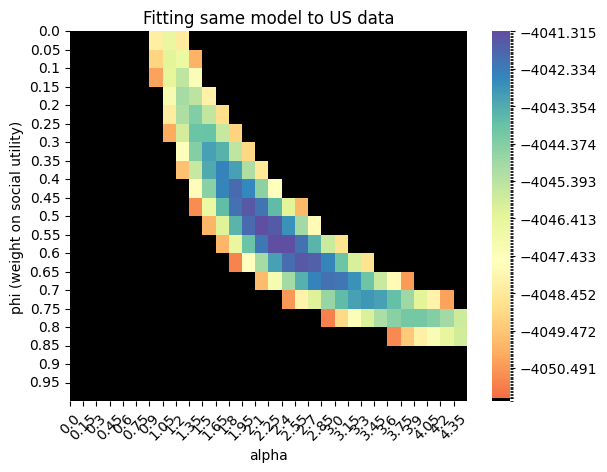

In [344]:
plot_overall_fit(dif_UK_logloss,possible_alpha,possible_phi,'Fitting same model to UK data',-10,utterences)
plot_overall_fit(dif_US_logloss,possible_alpha,possible_phi,'Fitting same model to US data',-10,utterences)
plot_overall_fit(dif_both_logloss,possible_alpha,possible_phi,'Fitting same model to US data',-10,utterences)
plot_overall_fit(dif_both_to_UK_logloss,possible_alpha,possible_phi,'Fitting same model to UK data',-10,utterences)
plot_overall_fit(dif_both_to_US_logloss,possible_alpha,possible_phi,'Fitting same model to US data',-10,utterences)

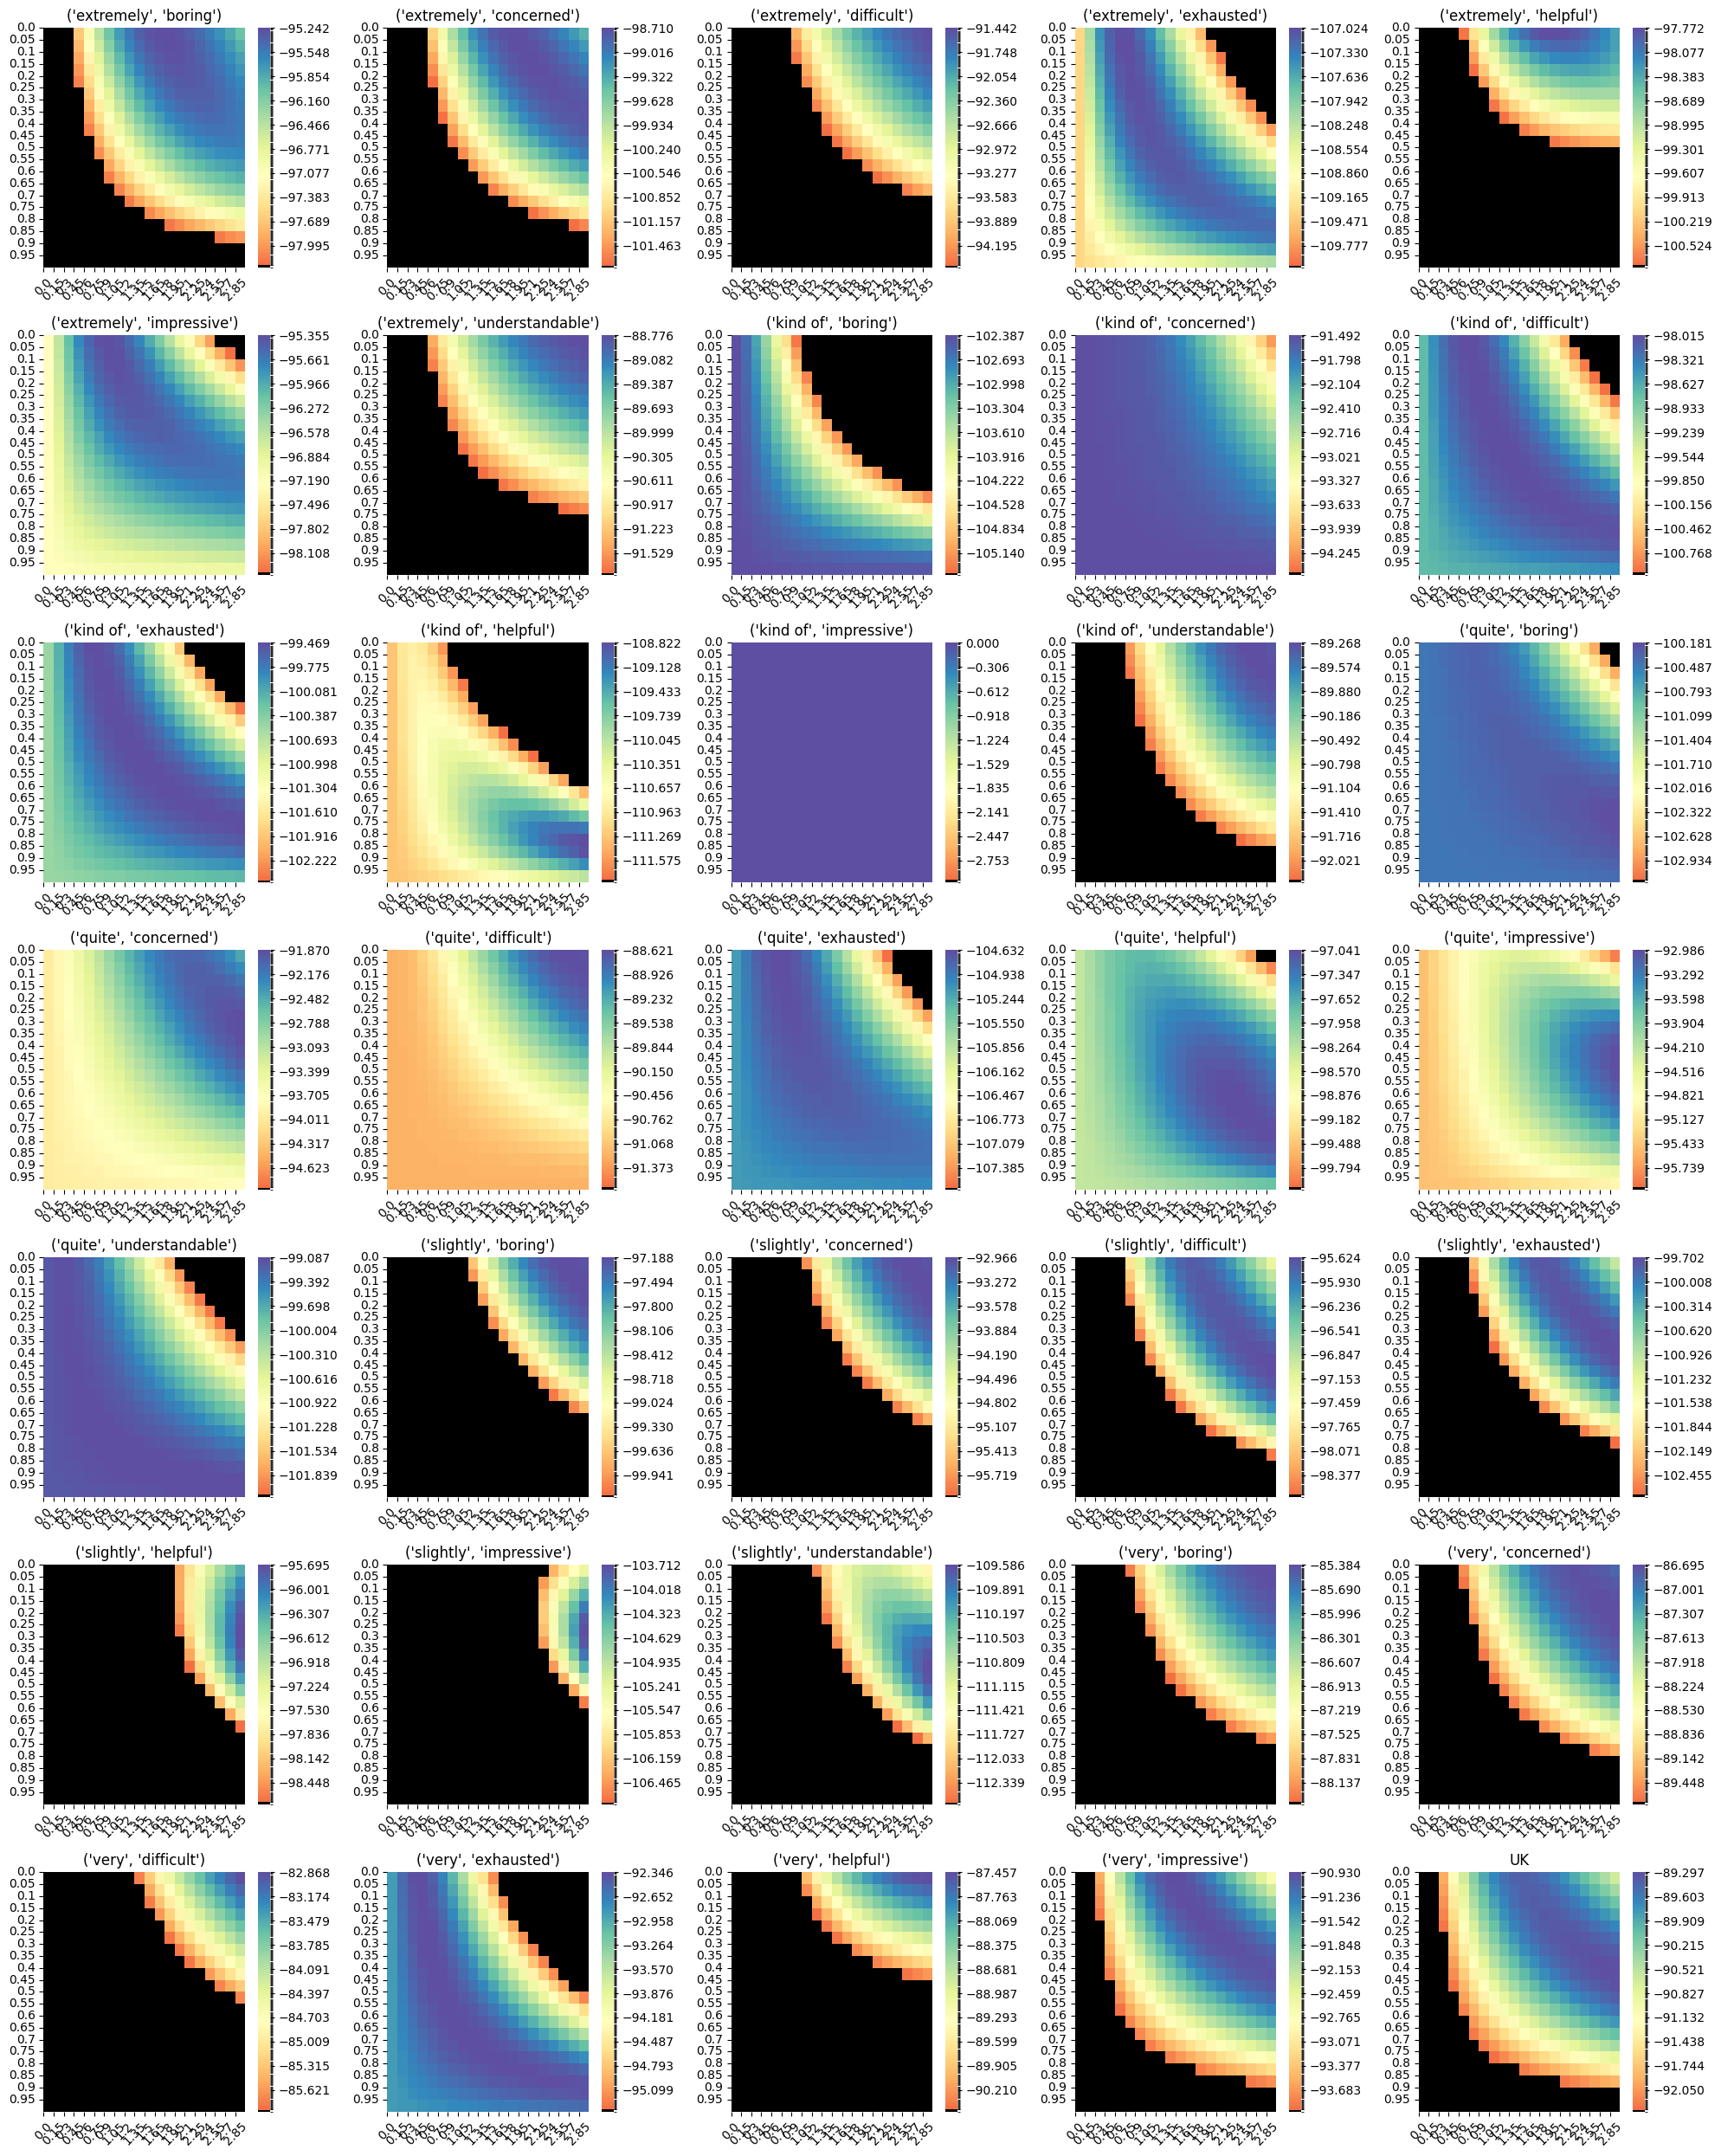

In [258]:
fit_per_utterance(dif_UK_logloss,"UK", possible_alpha, possible_phi)

# Using theta for obtaining U_inf function

Define $U_{inf}$ by first defining $P_{L_0}$(s|w) using threshold function

grid search (as opposed to optimizing)

Successfully doing parameter search

In [371]:
from scipy.optimize import minimize
states = np.arange(-5.7, 4.5, 0.1)
S = min(states)
def theta_U_s1(w,s,phi,U_inf):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*10)]
def theta_P_s1(alpha,phi,s,pred,U_inf):
    # corresponds to P_S1(w|s,phi)
    return softmax([ alpha*theta_U_s1((w,pred),s,phi,U_inf) for w in intensifiers])
def P_state(s):
    # return gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/(2*1**2))
# Define the function to minimize
def func_to_minimize(params):
    thetas = params[:5]
    alpha = params[5]
    phi = params[6]
    epsilon = 0.1
    theta_U_inf = dict()
    P_l1 = dict()
    for i in range(len(intensifiers)):
        theta_U_inf[intensifiers[i]] = np.array([epsilon*P_state(s) if s <= thetas[i] else P_state(s) for s in states])
        theta_U_inf[intensifiers[i]] = theta_U_inf[intensifiers[i]]/sum(theta_U_inf[intensifiers[i]])
        theta_U_inf[intensifiers[i]] = np.log(theta_U_inf[intensifiers[i]])
    for pred in predicates:
        P_grid = []
        for s in states:
            P_grid.append(theta_P_s1(alpha,phi,s,pred,theta_U_inf)*P_state(s))
        # swap rows and columns of P_grid
        P_grid = np.array(P_grid).T
        for i in range(len(intensifiers)):
            w = intensifiers[i]
            P_l1[(w,pred)] = P_grid[i]
            # normalize so adds up to 1
            P_l1[(w,pred)] = P_l1[(w,pred)]/np.sum(P_l1[(w,pred)])
    # print(P_l1[('slightly', 'helpful')])
    log_likelihood = 0
    for w in intensifiers:   
        for pred in predicates:
            measured_values = dialogue[((dialogue['intensifier'] == w) & (dialogue['predicate'] == pred))]['Z-Score Difference'].values
            log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values)
        #     print(log_likelihood,w,phi,alpha, thetas)
        # print(w)
    print(log_likelihood)
    return -log_likelihood

# Initial guess
initial_guess = [-3,-3,-3,-3,-3, 0.6,0]

# Define bounds for each parameter
bounds = [(-3, 2)] * 5 + [(0.5,2.4),(0,1)] # 5 parameters, each ranging from -6 to 6
print(bounds)
# Run the optimization
result = minimize(func_to_minimize, initial_guess, method='CG', bounds=bounds)

print("Optimal Parameters:", result.x)
print("Minimum Value:", result.fun)

[(-3, 2), (-3, 2), (-3, 2), (-3, 2), (-3, 2), (0.5, 2.4), (0, 1)]
-6492.709603945589
-6492.709603945589
-6492.709603945589
-6492.709603945589
-6492.709603945589


C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\2169232797.py:54: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(func_to_minimize, initial_guess, method='CG', bounds=bounds)
C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\2169232797.py:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values)


-6492.709603945589
-6492.709603945589
-6492.709603945589
Optimal Parameters: [-3.  -3.  -3.  -3.  -3.   0.6  0. ]
Minimum Value: 6492.709603945589


#### Record of results

Powell: 
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.54513784
  0.55593692]
Minimum Value: 7622.654024849191

SLSQP
Optimal Parameters: [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 5.24671918e-07 9.99998698e-01]
Minimum Value: 7773.548644439374

TNC:
Optimal Parameters: [0.         0.         1.         0.         0.         0.91291945, 1. ]
Minimum Value: 7773.548644439286

Nelder Mead:
Optimal Parameters: [ 0.0024747   0.0012909  -0.02271048  0.00263152  0.0018991   0.
  0.24250486]
Minimum Value: 7773.548644439286

trust-constr:
Optimal Parameters: [ 4.34396946e-08 -8.31980725e-09  1.00920297e+00  4.51582456e-08
  2.95320479e-08  1.54234285e+00  9.99406654e-01]
Minimum Value: 7773.710851762306

CG (starting from Powell):
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.91090539
  0.73335056]
Minimum Value: 7618.458113423883

BFGS
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.91090698
  0.73335143]
Minimum Value: 7618.458113423529

if epsilon = 0.01
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  1.01912567
  0.63853247]
Minimum Value: 7617.177330681999

Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  1.1721982
  0.66993666]
Minimum Value: 3540.0624957110535

UK - powell
Optimal Parameters: [-0.74820619  3.29998798 -0.35618854 -1.42530311 -1.30979051  0.71469205
  0.15471767]
Minimum Value: 3486.965957556221
US - Powell
Optimal Parameters: [-1.33231743  3.69999889 -0.90685264 -1.37751888 -1.96941291  0.66226507
  0.05043027]
Minimum Value: 4047.0662567772947

US - CG
Optimal Parameters: [-1.         -1.          0.         -1.         -2.          0.14551575
 -0.01626904]
Minimum Value: 4141.407529004872

all - CG (eps=0.01)
Optimal Parameters: [-1.         -1.          0.         -1.         -2.          5.76009058
  0.98151698]
Minimum Value: 7760.495904387104

all - powell (eps = 0.05)
Optimal Parameters: [-0.92819993  3.15148861 -0.46783021 -1.42192592 -1.64916572  0.86230122
  0.02336677]
Minimum Value: 7555.227659795885

all - powell (eps = 0.1)
Optimal Parameters: [-0.93643047  3.06772275 -0.46583885 -1.44719902 -1.46653402  1.13121295
  0.04682317]
Minimum Value: 7560.259834445015

In [ ]:
intensifiers

['very', 'slightly', 'extremely', 'quite', 'kind of']

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


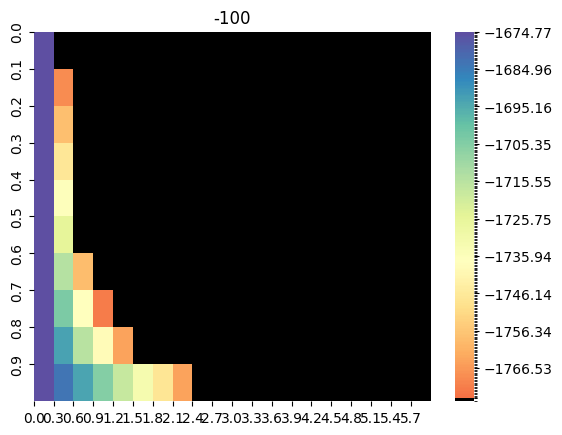

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


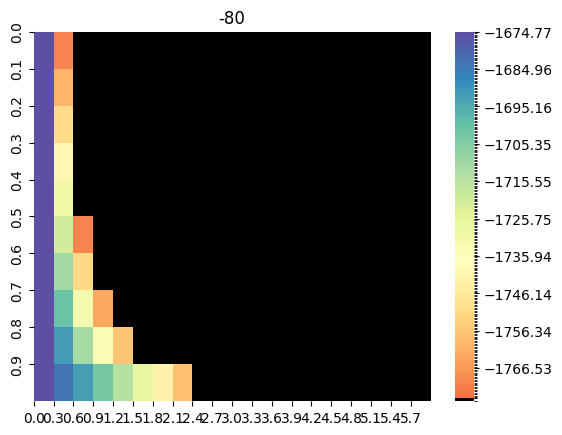

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


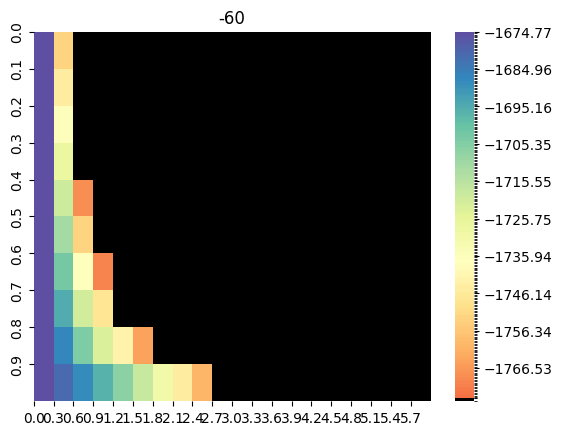

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


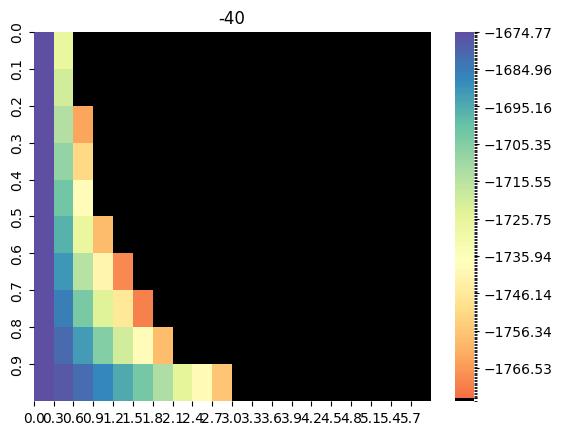

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


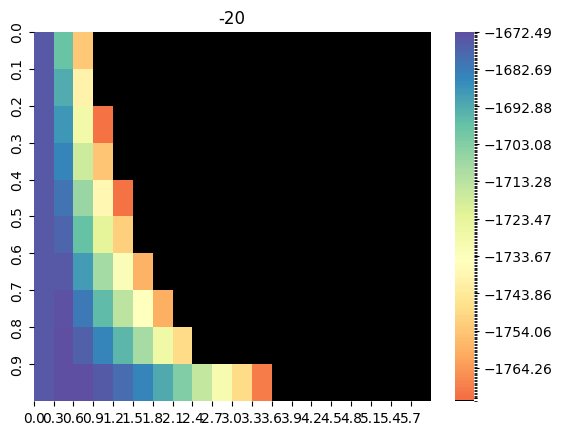

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


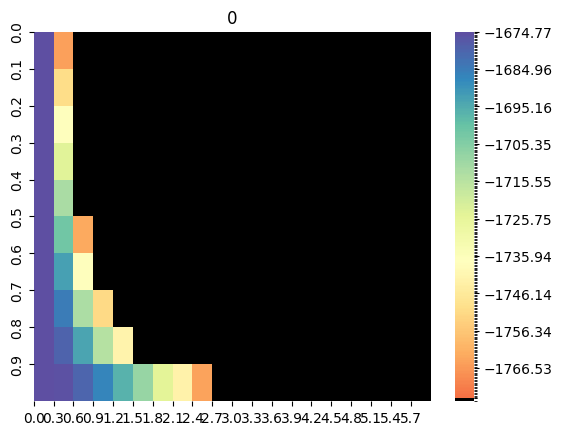

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


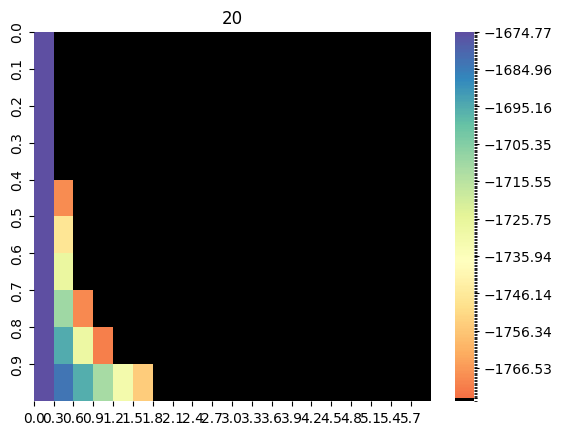

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


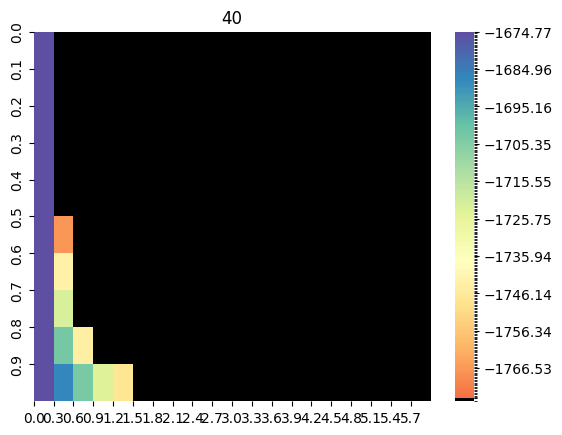

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


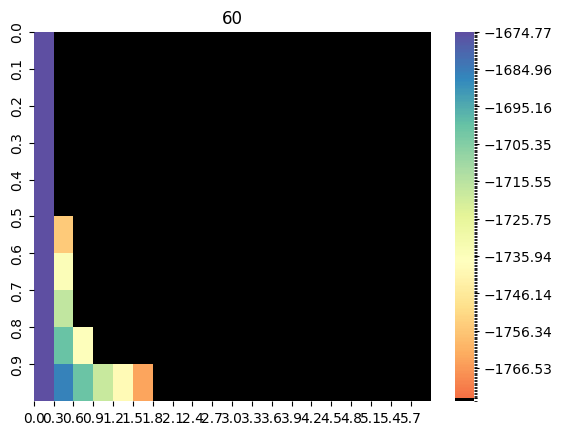

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


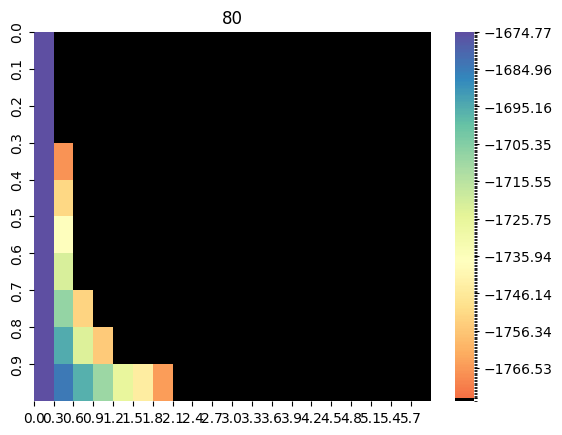

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


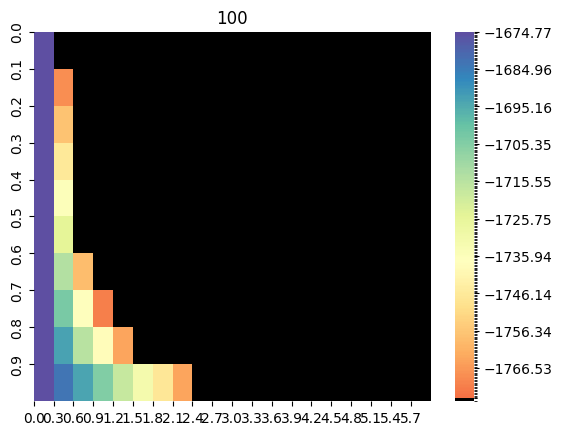

In [ ]:
def new_U_s1(w,s,phi,thresh):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*new_U_inf[(w[0],thresh)][s+100]
# s spans from -100 to 100
inten = 'extremely'
for thresh in [-100,-80,-60,-40,-20,0,20,40,60,80,100]:
    new_P_s1 = dict() # corresponds to P_S1(w|s,phi)
    for alpha in possible_alpha:
        for phi in possible_phi:
            for s in states:
                # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
                for pred in predicates:
                    new_P_s1[(alpha,phi,s,pred)] = softmax([ alpha*new_U_s1((w,pred),s,phi,thresh) if w == inten else alpha*U_s1((w,pred),s,phi)for w in intensifiers])
    # only thing left is computing P_l1
    new_P_l1 = dict()# corresponds to P_L1(s|w,phi)
    for alpha in possible_alpha:
        for phi in possible_phi:
            for pred in predicates:
                i = intensifiers.index(inten)
                w = intensifiers[i]
                P_l1[(alpha,phi,(w,pred))] = [new_P_s1[(alpha,phi,s,pred)][i]*P_state(s) for s in states]
                # normalize so adds up to 1
                P_l1[(alpha,phi,(w,pred))] = P_l1[(alpha,phi,(w,pred))]/np.sum(P_l1[(alpha,phi,(w,pred))])
    fit_judgement=dict()    
    for pred in predicates:
        fit_judgement[pred] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = dialogue[((dialogue['intensifier'] == inten) & (dialogue['predicate'] == pred))]['difference'].values
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)
    threshold = np.max(np.sum([fit_judgement[pred] for pred in predicates],axis=0))-100
    bounds = [-10000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[pred] for pred in predicates],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[pred] for pred in predicates],axis=0), cmap=custom_cmap,norm=norm, cbar=True)
    # label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label colors in heatmap
    plt.title(f'{thresh}')
    plt.show()
    
                
